<h1><center> Finance Project </h1></center>

## Script

### Initializing Libraries

In [1]:
# Basic Libraries
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Pre Processing Libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from statsmodels.api import add_constant
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve,auc
from imblearn.over_sampling import ADASYN
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
# Ml Libraries
from sklearn.svm import SVC
from statsmodels.api import Logit
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
warnings.filterwarnings('ignore')
train_size = 0.75
seed = 137

### Classes


#### Data Initialization Class

In [129]:
# Initialize Class to handle Data Frame I/O
  # Reading train/test data
  # train_test: has all training & tetsing data
  # predict: has all data to actually predict on.

class DataFrame:
    
    def __init__(self,train_size = 0.7, seed=137, dep_col="Revenue.Grid"):
      self.dep_col =  dep_col
      self.t_size = train_size
      self.seed = seed
      self.Model = None
      self.cutoffpoint = None

      # Reading
      self.train_test = pd.read_csv("finance_train.csv")
      self.predict = pd.read_csv("finance_test.csv")

      # Adding Source column to identify data type when caoncatenated
      # Source has 2 subcategories:-
        # train: training set
        # test : testing set
        # predict: Data to predict on

      #Initializing Independent and dependent feature
      self.X = self.train_test.drop(self.dep_col,axis=1).copy()
      self.y = self.train_test[self.dep_col].copy()
      self.X_predict = self.predict.copy()

      # Standard variables for split
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,
                                  self.y, train_size=self.t_size, random_state=self.seed)

      # Concatenating training and testing data
        # df consist of both train, test & predict data

      # Identification Column for train,test,predict
      self.X_train["source"] = "train"
      self.X_test["source"] = "test"
      self.X_predict["source"] = "predict"

      # Conactenating Independnet & Dependnet variable to form a single dataset
      self.train = pd.concat([self.X_train,self.y_train],axis=1)
      self.test = pd.concat([self.X_test,self.y_test],axis=1)
      self.predict = self.X_predict.copy()

      # Initializing single dataset
      self.df = pd.concat([self.train,self.test,self.predict],axis=0)
      self.df.reset_index(inplace=True,drop=True)

    def __repr__(self):
      display(self.df)
      return str(self.df.shape)

    # To re sample Data if required
    def sampling(self):
      if "source_train" in self.df.columns.values:
        self.sampling_dummies()
        return
      
      self.X = self.df[self.df["source"] != "predict"].drop([self.dep_col],axis=1).copy()
      self.y = self.df[self.df["source"] != "predict"][self.dep_col].copy()
      self.X_predict = self.df[self.df["source"] == "predict"].drop("Revenue.Grid",axis=1).copy()

      # Standard variables for split
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,
                                      self.y, train_size=self.t_size, random_state=self.seed)
      
      

      self.X = self.df.drop([self.dep_col],axis=1).copy()
      self.y = self.df[self.dep_col].copy()

      # Concatenating training and testing data
        # finance_df consist of both train and test data

      # Conactenating Independnet & Dependnet variable to form a single dataset
      self.train = pd.concat([self.X_train,self.y_train],axis=1)
      self.test = pd.concat([self.X_test,self.y_test],axis=1)
      self.predict = self.X_predict.copy()

      self.X_train.drop(["source"],axis=1,inplace=True)
      self.X_test.drop(["source"],axis=1,inplace=True)

    def sampling_dummies(self):
      self.X = self.df[(self.df["source_train"] == 1) | (self.df["source_test"] == 1)].drop(
                                                                    [self.dep_col],axis=1).copy()
      self.y = self.df[(self.df["source_train"] == 1) | (self.df["source_test"] == 1)][
                                                                    self.dep_col].copy()
      self.X_predict = self.df[(self.df["source_train"] == 0) & (self.df["source_test"] == 0)].drop(
                                                                  "Revenue.Grid",axis=1).copy()
      # Standard variables for split
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,self.y,
                                               train_size=self.t_size, random_state=self.seed)

      # Concatenating training and testing data
        # finance_df consist of both train and test data

      self.X = self.df.drop([self.dep_col],axis=1).copy()
      self.y = self.df[self.dep_col].copy()
      
      # Conactenating Independnet & Dependnet variable to form a single dataset
      self.train = pd.concat([self.X_train,self.y_train],axis=1)
      self.test = pd.concat([self.X_test,self.y_test],axis=1)
      self.predict = self.X_predict.copy()

      self.X_train.drop(["source_train","source_test"],axis=1,inplace=True)
      self.X_test.drop(["source_train","source_test"],axis=1,inplace=True)

      # Initializing single dataset

    def info(self):
      display(self.df)
      display(self.df.info())
      display(self.df.describe(include="all").T)

    def drop_identifier(self):
      self.df.drop("REF_NO",axis=1,inplace=True)



#### Imputer Class

In [130]:
class Imputer(DataFrame):

    def mice(self,missing_value = "Unknown",missing_indic=False): 

        mice = IterativeImputer(estimator=DecisionTreeClassifier(),
                                missing_values=missing_value, add_indicator=missing_indic)
        mice.fit(self.df.drop(self.dep_col,axis=1))
        mice.transform(self.df.drop(self.dep_col,axis=1))
        self.sampling()

        
    def knn(self,missing_value = "Unknown",missing_indic=False):
        
        knn = KNNImputer(missing_values=missing_value,n_neighbors=5, 
                                            weights="distance",add_indicator=missing_indic)
        knn.fit(self.df.drop(self.dep_col,axis=1))
        knn.transform(self.df.drop(self.dep_col,axis=1))
        self.sampling()

    def mean_median_mode(self,col,nan=None):
        if self.df[col].dtype == "object":
            temp_mode = self.df[col].mode()[0]
            self.df[col] = np.where(self.df[col] ==  nan, temp_mode, self.df[col])
        else:
            temp_median = self.df[col].median()
            self.df[col] = np.where(self.df[col] == nan, temp_median, self.df[col])

    # manually
    def region_imputer(self):
        # Dataframe for UK region vs post code
        uk_df = pd.read_excel("uk_postcode.xlsx")

        # Region is Unknown
        unknown_df = self.df[self.df["region"] == "Unknown"].copy()
        unknown_df["post_prefix"] = unknown_df["post_code"].str.slice(0,2).copy()

        for i in range(len(unknown_df)):
            post_code = unknown_df["post_prefix"].iloc[i]

            if post_code.isalpha() == False:
                unknown_df["post_prefix"].iloc[i] = unknown_df["post_prefix"].iloc[i][:1]

            unknown_df["region"].iloc[i] = uk_df[uk_df["Postcode prefix"] == 
                                    unknown_df["post_prefix"].iloc[i]]["UK region"].iloc[0]

        self.df["region"][self.df["region"] == "Unknown"] = unknown_df["region"].copy()

        
    def imputer(self):
        # # Age_band
        self.mean_median_mode("age_band", "Unknown")

        # # Status
        self.mean_median_mode("status", "Unknown")

        # Occupation
        age_band = ["61-65","65-70","71+"]
        for band in age_band:
            self.df[(self.df["age_band"] == band) & (self.df.occupation == 
                                                "Unknown")]["occupation"] = "Retired"

        self.df[(self.df["age_band"] == "18-21")]["occupation"] = "Student"

        #Region
        self.region_imputer()
        self.sampling()
    


#### Encoding Class


In [131]:
class Encoding(Imputer):
    
    def ordinal_encode(self,col,dict,dtype="int",cast=True):

        # Encoding
        self.df[col].replace(dict,inplace=True)
        
        # If Encode as Continuous
        if dtype == "int" and cast == True: 
            self.df[col] = self.df[col].astype(np.int16)

        # If Encode as Categorical
        if dtype == "object":
            self.df[col] = self.df[col].astype("object")


    def mean_encoder(self,col,dep_col,subcategory, rank=False):

        self.sampling()
        value_df = self.df[col].value_counts()

        for i in range(len(value_df)):


            # Collecting which value to encode
            value_to_encode = value_df.index[i] 

            # Total no of times Revenue is 2 for particular age_band
            total_count_subcat = len(self.train[col][(self.train[col] == value_to_encode) & (
                                                            self.train[dep_col] == subcategory)])

            # Total length of dataframe
            total_outcomes = len(self.df[col])

            # Proportion value
            proportion = total_count_subcat/total_outcomes

            # Assigning Proportion to dataset
            self.df[col][self.df[col] == value_to_encode] = proportion



        # If I want to assign rank instead of Mean Values
        if rank == True:
            # Sorts data on basis of rank
            value_df = self.df[col].value_counts().sort_index()

            # Assign the rank
            for i in range(len(value_df)):
                value_to_encode = value_df.index[i]
                self.df[col][self.df[col] == value_to_encode] = i
    
        self.df[col] = self.df[col].astype(np.int16)
    
    
    def label_encoder(self,col, start_point=0):
        value_df = self.df[col].value_counts().sort_values()

        for i in range(len(value_df)):
            value_to_encode = value_df.index[i]
            self.df[col][self.df[col] == value_to_encode] = i + start_point

        self.df[col] = self.df[col].astype(np.int16)


    def encode_mean(self,preference=1,rank=True):
        # age_band
        self.mean_encoder("age_band","Revenue.Grid",preference,rank)

        # TVarea
        self.mean_encoder("TVarea","Revenue.Grid",preference,rank)

        # post_code
        self.mean_encoder("post_code","Revenue.Grid",preference,rank)

        # post_area
        self.mean_encoder("post_area","Revenue.Grid",preference,rank)

         # Region
        self.mean_encoder("region","Revenue.Grid",preference,rank)


    def encode_label(self):
                # children
        continuous_children_dict = {
                    "1":1,
                    "2":2,
                    "3":3,
                    "4+":4,
                    "Zero":0
        }     
        categorical_children_dict = {
                    "1":"One",
                    "2":"Two",
                    "3":"Three",
                    "4+":"Four+",
                    "Zero":"Zero"
                }
        self.ordinal_encode("children",categorical_children_dict, dtype="object")

        # occupation
        occupation_dict = {
                    "Professional":9,
                    "Retired":8,
                    "Secretarial/Admin":7,
                    "Housewife":6,
                    "Business Manager":5,
                    "Unknown":4,
                    "Manual Worker":3,
                    "Student":2,
                    "Other":1
        }
        self.ordinal_encode("occupation",occupation_dict)


        # occupation_partner
        occupation_dict = {
                    "Professional":9,
                    "Retired":8,
                    "Secretarial/Admin":7,
                    "Housewife":6,
                    "Business Manager":5,
                    "Unknown":4,
                    "Manual Worker":3,
                    "Student":2,
                    "Other":1
        }
        self.ordinal_encode("occupation_partner",occupation_dict)

        occupation_dict = {
                    "Professional":9,
                    "Retired":8,
                    "Secretarial/Admin":7,
                    "Housewife":6,
                    "Business Manager":5,
                    "Unknown":4,
                    "Manual Worker":3,
                    "Student":2,
                    "Other":1
        }
        rg_dict = {
            1.0 :0,
            2.0 :1
        }
        self.ordinal_encode(self.dep_col,rg_dict,cast=False)

        # year_last_moved
        # self.df["year_last_moved"] =  np.where(self.df[
        #             "year_last_moved"] != 0 , 2023 - self.df["year_last_moved"].values,0) 

        # self.df["year_last_moved"] = self.df["year_last_moved"].astype(dtype=np.int16)
        
        # family_income
        # self.label_encoder("family_income")
        # self.label_encoder("post_code")
        # self.label_encoder("post_area")

        family_income_dict = {
            ">=35,000"             : "35,000 >",
            "<27,500, >=25,000"    : "25,000 - 27,500",
            "<30,000, >=27,500"    : "27,500 - 30,000",
            "<25,000, >=22,500"    : "22,500 - 25,000",
            "<20,000, >=17,500"   : "17,500 - 20,000",
            "<12,500, >=10,000"    : "10,000 - 12,500",
            "<17,500, >=15,000"    : "15,000 - 17,500",
            "<15,000, >=12,500"    : "12,500 - 15,000",
            "<22,500, >=20,000"    : "20,000 - 22,500",
            "<10,000, >= 8,000"    : "8,000 - 10,000",
            "< 8,000, >= 4,000"    : "4,000 - 8,000",
            "< 4,000"              : "4,000 <",
            "Unknown"              : "Unknown"
        }

        self.ordinal_encode("family_income",family_income_dict,dtype="object")
       

    def re_encode(self):
        rg_dict = {
            0.0 :1,
            1.0 :2
        }
        self.ordinal_encode(self.dep_col,rg_dict,cast=False)
        self.sampling()

    def encode_binary(self):
        # home_status
        home_status_dict = {
            "Unclassified" : 0,
            "Rent Privately" : 0,
            "Rent from Council/HA" : 0,
            "Own Home": 1,
            "Live in Parental Hom" : 0
        }
        
        self.ordinal_encode("home_status",home_status_dict)

        # self_employed
        self.label_encoder("self_employed")

        # self_employed_partner
        self.label_encoder("self_employed_partner")

        
    def encode(self,preference=1,ignore_bin=False,rank=True):
        if ignore_bin == False:
            self.encode_mean(preference=preference,rank=rank)
            self.encode_label()
            self.encode_binary()
            self.sampling()
        else:
            self.encode_label()
            self.encode_mean(preference)
            self.sampling()


    def dummies(self,drop_first=True):
        self.sampling()
        self.df = pd.get_dummies(self.df,drop_first=drop_first)
        self.sampling_dummies()

    def basic_encode(self):
        categorical_children_dict = {
                    "1":"1",
                    "2":"2",
                    "3":"3",
                    "4+":"4+",
                    "Zero":"0"
                }
        continuous_children_dict = {
                    "1":1,
                    "2":2,
                    "3":3,
                    "4+":4,
                    "Zero":0
        }     
        self.ordinal_encode("children",categorical_children_dict,dtype="object")
        
        self.df["year_last_moved"] = self.df["year_last_moved"].astype(dtype=np.int16)
        self.df["year_last_moved"] = self.df["year_last_moved"].astype(dtype="object")


        revenue_dict = {
                    1.0:"High Revenue",
                    2.0:"Low Revenue"
                    
                }
        self.ordinal_encode(self.dep_col,revenue_dict,dtype="object")

        family_income_dict = {
            ">=35,000"             : "35,000 >",
            "<27,500, >=25,000"    : "25,000 - 27,500",
            "<30,000, >=27,500"    : "27,500 - 30,000",
            "<25,000, >=22,500"    : "22,500 - 25,000",
            "<20,000, >=17,500"   : "17,500 - 20,000",
            "<12,500, >=10,000"    : "10,000 - 12,500",
            "<17,500, >=15,000"    : "15,000 - 17,500",
            "<15,000, >=12,500"    : "12,500 - 15,000",
            "<22,500, >=20,000"    : "20,000 - 22,500",
            "<10,000, >= 8,000"    : "8,000 - 10,000",
            "< 8,000, >= 4,000"    : "4,000 - 8,000",
            "< 4,000"              : "4,000 <",
            "Unknown"              : "Unknown"
        }

        self.ordinal_encode("family_income",family_income_dict,dtype="object")

            

#### Feature Engineering

In [132]:
class Feature(Encoding):

    def outlier(self,columns_to_ignore=None):

        # self.sampling()
        outliers_treated = list()

        continuous_vars = self.df.columns[(self.df.dtypes != "object") & (self.df.columns != "year_last_moved") ]

        for col in continuous_vars:
            Q1 = np.quantile(self.df[col],0.25)
            Q3 = np.quantile(self.df[col], 0.75)
            IQR = Q3-Q1

            lowerbound = Q1 - 1.5*IQR
            upperbound = Q3 + 1.5*IQR
            
            if (min(self.df[col]) < lowerbound) or (max(self.df[col]) > upperbound):
                outliers_treated.append(col)

            if min(self.df[col]) < lowerbound:
                self.df[col] = np.where(self.df[col] < lowerbound ,lowerbound,self.df[col]).copy()
                
            if max(self.df[col]) > upperbound:
                self.df[col] = np.where(self.df[col] > upperbound,upperbound,self.df[col]).copy()
            

        print("="*90)
        print("Outliers Treated:-",outliers_treated)
        self.sampling()
        


    def log_transform(self,col_to_avoid=[]):
        for col in self.df.columns[self.df.dtypes != "object"]:
            if col not in ["Source", self.dep_col] + col_to_avoid:
                self.df[col] = np.log(np.where(self.df[col] == 0,1, self.df[col]))

    # Power Transformation
    def powertransformer(self):
        self.sampling()
        transformer = PowerTransformer(method='box-cox')
        
        transformer.fit(self.X_train.drop(self.X_train.columns[self.X_train.
        dtypes == "object"] ,axis=1) + 0.001)

        X_transformed = pd.DataFrame(transformer.transform(self.X.drop(self.X.columns[self.X.
        dtypes == "object"] ,axis=1) + 0.001), columns = self.X.columns[self.X.dtypes != "object"])

        categorical_cols = self.X.columns[self.X.dtypes == "object"]
        
        self.X = pd.concat([self.X[categorical_cols], X_transformed], axis=1)
        self.df = pd.concat([self.X,self.y],axis=1)

        self.sampling()

    def transform(self,type="box_cox"):

        min_bal = min(self.df["Portfolio.Balance"]) - 1
        self.df["Portfolio.Balance"] = abs(min_bal) + self.df["Portfolio.Balance"].values
        
        self.sampling()

        if type == "log":
            self.log_transform()
        elif type == "box-cox":
            self.powertransformer()

        self.sampling()
        
        # print(self.df.isnull().sum())


    def feature_selection(self,threshold=0.01):
        
        feat_labels = self.X_train.columns.values
        features_imp = RandomForestClassifier(n_estimators=999,random_state=137).fit(self.X_train,
                                                                                    self.y_train)
        
        sfm = SelectFromModel(features_imp,threshold=threshold).fit(self.X_train, self.y_train)

        selected_feature = list()

        for feature in sfm.get_support(indices=True):
            selected_feature.append(feat_labels[feature])
        print("="*90)
        print("Selected features:-")
        print(selected_feature)
        
        self.df = pd.concat([self.df[selected_feature],self.df[self.dep_col],self.df[[
        "source_train","source_test"]]],axis=1).copy()
        self.sampling_dummies()


    def pvalue(self,p=0.05):
        # Seleting Feature on direct relationship with Independent Columns

        pval = p
        maxpval = p

        X_train = self.X_train.copy()

        highpcolumns = list()

        while pval >= maxpval:
            tempp_df = pd.DataFrame()
            tempmodel = Logit(self.y_train,X_train).fit()

            tempp_df["p"] = tempmodel.pvalues
            tempp_df["Column"] = X_train.columns
            tempp_df.dropna(inplace=True)
            pval =  tempp_df.sort_values("p", ascending=False).iloc[0,0]
            tempcolumn = tempp_df.sort_values("p", ascending=False).iloc[0,1]

            if pval >= maxpval:
                X_train.drop(tempcolumn,axis=1,inplace=True)
                highpcolumns.append(tempcolumn)

        try:
            highpcolumns.remove("const") 
        except Exception as e:
            pass
        
        print("="*90)
        print(f'High Pvalues Features: \n{highpcolumns}')

        self.X_train.drop(highpcolumns,axis=1,inplace=True)
        self.X_test.drop(highpcolumns,axis=1,inplace=True)

    def add_constant(self):
        self.X_train = add_constant(self.X_train)
        self.X_test = add_constant(self.X_test)

    def vif(self,vif=10):
    # Handling Multicolinearity in Dataset

        tempvif = vif
        tempmaxvif = vif
        X_train = self.X_train.copy()
        highvifcolumns = list()

        while(tempvif >= tempmaxvif):
            tempvif_df = pd.DataFrame()
            tempvif_df["VIF"] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
            tempvif_df["Column"] = X_train.columns
            tempvif_df.dropna(inplace=True)

            tempcolumn = tempvif_df.sort_values(["VIF"],ascending=False).iloc[0,1]
            tempvif = tempvif_df.sort_values(["VIF"],ascending=False).iloc[0,0]

            if tempvif >= tempmaxvif:
                X_train.drop(tempcolumn,axis=1,inplace=True)
                highvifcolumns.append(tempcolumn)
        try:
            highvifcolumns.remove("const") 
        except Exception as e:
            pass
        print("="*90)
        print(f'High VIF Features: \n{highvifcolumns}')
        self.X_train.drop(highvifcolumns,axis=1,inplace=True)
        self.X_test.drop(highvifcolumns, axis=1,inplace=True)

    def feature_construction(self):
        
        occupation_dict = {
                    "Professional":9,
                    "Retired":8,
                    "Secretarial/Admin":7,
                    "Housewife":6,
                    "Business Manager":5,
                    "Unknown":4,
                    "Manual Worker":3,
                    "Student":2,
                    "Other":1
        }
        self.ordinal_encode("occupation",occupation_dict)

        # Investment Portfolio = term deposit + equity + debentures + taxrebatebonds
        self.df["Investment_Portfolio"] = self.df["Term.Deposit"] + self.df[
            "Investment.in.Equity"] +self.df["Investment.Tax.Saving.Bond"] + self.df[
            "Investment.in.Mutual.Fund"] + self.df["Investment.in.Commudity"] + self.df[
            "Investment.in.Derivative"]
        
        # Total Debt = personal loan + homeloan + credit card balance + balance transfer
        self.df["Total_Debt"] = self.df["Personal.Loan"] + self.df["Home.Loan"] + self.df[
            "Average.Credit.Card.Transaction"] + self.df["Balance.Transfer"]

        #1. Customers who can take car loan - rank above 5 in occupation
        self.df["Car_Loan_Ability"] = np.where(self.df["occupation"] > 5,1,0)

        # 2. Customers who can take credit card - who does not have credit card/ balance transfer
        self.df["Credit_Card_Issue"] = np.where((self.df["Balance.Transfer"] == 0) & (
                                self.df["Average.Credit.Card.Transaction"] == 0) ,1,0 )

        #3. Customers who can invest in mutual funds- whoever has zero equity, derivative portfolio
        self.df["Invest_Mutual_Funds"] = np.where((self.df["Investment.in.Equity"] == 0) & (
                                self.df["Investment.in.Derivative"] == 0) ,1,0)

        #4. Education loan - can be given to students
        # self.df["Education_Loan_Eligibility"] = np.where(self.df["occupation"] == 0,1,0)

        #5. Pension scheme (insurance) - can be given to working age population (21-55)
        # self.df["Insurance"] = np.where((self.df["age_band"] != 0) & (self.df[
        # "age_band"] != "55-60") &(self.df["age_band"] != "61-65") &(self.df[
        # "age_band"] != "65-70") & (self.df["age_band"] != "71+"),1,0)

        # 6. Home loan- can be given to people (who lives in rented apartment or parental home)(
        # except own home)
        self.df["Home_Loan_Eligibility"] = np.where((self.df["Home.Loan"] == 0) & (
                                                             self.df["home_status"] != 1),1,0)

        #7. Fd - account balance is significant. Whatever about the minimum balance can be 
        # invested in fd
        self.df["Term_Deposit_Eligibility"] = np.where((self.df["Term.Deposit"] == 0) & (
                                                        self.df["Average.A.C.Balance"] > 2),1,0)
                                                       
        #8. Personal loan can be given to anyone having an occupation above 18years of age. 
        # Whoever earns.
        # self.df["Personal_Loan_Eligibility"] = np.where((self.df["age_band"] > 1) & (
        # self.df["family_income"] > 1 ),1,0)

        #9. Taxrebate bonds can be given to anyone having high salary ( above 5ranks same as 1). 
        # As high salary means high taxes.
        self.df["Taxrebate_Bonds_Eligibility"] = np.where((self.df["occupation"] > 5) & (
                                                self.df["Investment.Tax.Saving.Bond"] == 0),1,0)

        #10. Inverstment/Debt Ratio
        self.df["Investment_Debt_Ratio"] = np.where(self.df["Total_Debt"] != 0,self.df[
            "Investment_Portfolio"] / self.df["Total_Debt"],self.df["Investment_Portfolio"])

        self.sampling()

    def scaling(self):
        # Scaling that happens only on Independent Columns
        self.sampling()

        dummy_col_1 = "source_train"
        dummy_col_2 = "source_test"

        if dummy_col_1 in self.X.columns:
            scaler = StandardScaler().fit(self.X_train)

            X_scaled = pd.DataFrame(scaler.transform(self.X.drop(["source_train",
            "source_test"],axis=1)), columns= self.X.drop(["source_train","source_test"],
                                                                        axis=1).columns)
            self.X = pd.concat([X_scaled,self.X[["source_train","source_test"]] ],axis=1)
     
        else:
            drop_cols = self.X.columns.values[self.X.dtypes == "object"]
            scaler = StandardScaler().fit(self.X_train.drop(drop_cols,axis=1))
            X_scaled = pd.DataFrame(scaler.transform(self.X.drop(drop_cols,axis=1)), columns= self.X.drop(
                drop_cols, axis=1).columns)
            self.X = pd.concat([X_scaled,self.X[drop_cols] ],axis=1)
     
        
        self.df = pd.concat([self.X,self.y],axis=1).copy()
        self.sampling()

    def smote(self):
        self.sampling()
        print("="*90)
        print(f'Pre SMOTE: {Counter(self.y_train)}')
        smt = SMOTE(n_jobs=60)
        self.X_train, self.y_train = smt.fit_resample(self.X_train,self.y_train)
        print(f'Post SMOTE: {Counter(self.y_train)}')

    def adasyn(self):
        self.sampling()
        print("="*90)
        print(f'Pre SMOTE: {Counter(self.y_train)}')
        smt = ADASYN(n_jobs=60)
        self.X_train, self.y_train = smt.fit_resample(self.X_train,self.y_train)
        print(f'Post SMOTE: {Counter(self.y_train)}')



#### Analysis

In [133]:
class Analysis(Feature):

    def event_rate(self):
        event_df = self.y_train.value_counts(normalize=True)*100
        display(event_df)     
        
    def bivaraiate_anlaysis(self):
        # Resample data
        self.sampling()
        # Automating Data Visualization

        # Heatmap - To find relationship between continuous values
        continuous_vars = self.train.columns[self.train.dtypes != 'object']
        self.heatmap(self.df[continuous_vars].corr())

        # Scatter Plot 
        scatter_vars = ["cement",'water'] + ["blast_furnace_slag",'fly_ash','superplasticizer']
        for col in scatter_vars:
            self.scatterplot(col)
        
        # Box Plot
        bar_vars = "age"
        self.boxplot(bar_vars)


    def heatmap(self,corrDf = None):
        continuous_vars = self.train.columns[(self.train.dtypes != 'object') & (
                                            self.train.columns.values != self.dep_col )]
        corrDf = self.train[continuous_vars].corr()
        plt.figure(figsize=(20,10))
        sns.heatmap(corrDf,
                    cmap="turbo_r",
                    annot=True)
        plt.show()
        
    def pairplot(self):
        plt.figure(figsize=(20,20))
        tempdf = self.train.drop("Source",axis=1)
        sns.pairplot(data=tempdf)
        plt.show()
        
    def scatterplot(self,feature):
        plt.figure(figsize=(20,10))
        sns.scatterplot(x=self.train[feature], y=self.train[self.dep_col])
        plt.show()

    def histplot(self,feature):
        if type(feature) != str:
            for col in feature:
                print(col,":-")
                plt.figure(figsize=(15,8))
                sns.histplot(x=self.train[col], hue=self.train[self.dep_col])
                plt.xticks(rotation=45)
                plt.show()
        else:
            sns.histplot(x=self.train[feature], hue=self.train[self.dep_col])
            plt.show()

    def histplot_continuous(self,feature):
        if type(feature) != str:

            for col in feature:
                plt.figure(figsize=(15,6))
                print(col,":-")
                plt.subplot(121)
                # sns.histplot(x=self.train[col][self.train[col] != min(self.train[col])], 
                            #  hue=self.train[self.dep_col])
            
                sns.histplot(x=self.train[col], hue=self.train[self.dep_col],kde=True,alpha=0.5)


                plt.subplot(122)
                stats.probplot(self.train[col],dist="norm", plot=plt)
                # plt.xticks(rotation=45)
                plt.show()
        else:
            sns.histplot(x=self.train[feature], hue=self.train[self.dep_col])
            plt.show()

    def countplot(self,feature):
        if type(feature) != str:
            for col in feature:
                print(col,":-")
                plt.figure(figsize=(15,8))
                sns.countplot(x=self.train[col],hue=self.train[self.dep_col])
                plt.xticks(rotation=45)
                plt.show()
        else:
            sns.countplot(x=self.train[feature],hue=self.train[self.dep_col])
            plt.show()

    def distplot(self,feature):
        if type(feature) != str:
            for col in feature:
                print(col,":-")
                plt.figure(figsize=(15,8))
                sns.distplot(self.train[col])
                plt.xticks(rotation=45)
                plt.show()
        else:
            sns.distplot(self.train[feature])
            plt.show()

    def boxplot(self,feature):
        if type(feature) != str:
            for col in feature:    
                print(col,":-")
                plt.figure(figsize=(15,8))    
                sns.boxplot( y= self.train[col], x= self.train[self.dep_col])
                plt.show()
        else:
            plt.figure(figsize=(15,8))
            sns.boxplot( y= self.train[feature],x= self.train[self.dep_col])
            plt.show()


####  Model

In [154]:
class Model(Analysis):

    def logistic_regression(self):
        self.Model = LogisticRegression(solver='newton-cg').fit(self.X_train,self.y_train)
        
        # print(self.Model.summary())
        self.y_predict = self.Model.predict(self.X_test)

    def random_forest(self):
        self.Model = RandomForestClassifier(random_state=137).fit(self.X_train, self.y_train)
        self.y_predict = self.Model.predict(self.X_test)

    def tuned_random_forest(self):

        self.Model = RandomForestClassifier(random_state=137,n_estimators=49,min_samples_split=8,
                    min_samples_leaf=2,max_features=4, max_depth=100,bootstrap=True).fit(self.X_train,self.y_train)
        self.predict = self.Model.predict(self.X_test)

    def svm(self):
        self.Model = SVC(probability=True).fit(self.X_train,self.y_train)
        self.y_predict = self.Model.predict(self.X_test)

    def tuned_svm(self):
        self.Model = SVC(kernel='rbf',gamma=0.01,C=385,probability=True).fit(self.X_train,self.y_train)
        self.y_predict = self.Model.predict(self.X_test)

    def svm_boost(self):
        self.Model = AdaBoostClassifier(base_estimator =  SVC(kernel='rbf',gamma=0.006,C=260,probability=True)
                                        ,n_estimators=100,learning_rate = 0.1,random_state=137)

        self.Model.fit(self.X_train,self.y_train)
        self.y_predict = self.Model.predict(self.X_test)

    
    def knn(self):
        self.Model = KNeighborsClassifier().fit(self.X_train,self.y_train)
        self.y_predict = self.Model.predict(self.X_test)
        
    def tuned_knn(self):
        self.Model = KNeighborsClassifier(weights='uniform',p=4,
                                          n_neighbors=3,leaf_size=30).fit(self.X_train,self.y_train)
        self.y_predict = self.Model.predict(self.X_test)

    def naive_bayes(self):
        self.Model = GaussianNB().fit(self.X_train,self.y_train)
        self.y_predict = self.Model.predict(self.X_test)

    def grad_boost(self):
        self.Model = GradientBoostingClassifier(random_state=137).fit(self.X_train, self.y_train)
        self.y_predict = self.Model.predict(self.X_test)

    def tuned_grad_boost(self):
        self.Model = GradientBoostingClassifier(random_state=137,n_estimators=349,min_samples_split=4,
                                                min_samples_leaf=12,max_features=10,max_depth=3,
                                                learning_rate=0.3).fit(self.X_train, self.y_train)
        self.y_predict = self.Model.predict(self.X_test)
        

    def pca(self,n=2):
        df = self.X[self.X.columns[self.X.dtypes != "object"]].copy()
        PCA_Model = PCA(n_components = n).fit(df)
        self.df = pd.concat([self.df, pd.DataFrame(PCA_Model.transform(df),columns = ["PCA1","PCA2"])],axis=1)
        self.sampling()


        
    def evaluate(self):
        print("="*90)
        print("Confusion Matrix:-\n",pd.crosstab(self.y_test,self.y_predict))
        print("="*90)
        print(classification_report(self.y_test,self.y_predict))

        dict_compare = {    
            "True":self.y_test,
            "Predict": self.y_predict
        }
        compare_df = pd.DataFrame(dict_compare)
        
        return pd.concat([self.X_test,compare_df],axis=1)

    def hyper_param(self,model,param,search="random",verbose=0,score="f1",samples=500):
        # Random Search - For Faster Results
        if search == 'random':
            randomsearch = RandomizedSearchCV(estimator = model, param_distributions = param,scoring=score,
                                                                             n_iter = samples, cv = 3, verbose=verbose, random_state=137,n_jobs=60)
            randomsearch.fit(self.X_train, self.y_train) 

            print("\nBest Parameters:- ")
            print("="*90)
            print(randomsearch.best_params_)
            print("-"*90+'\n')

            self.hyperparam_df = pd.DataFrame.from_dict(randomsearch.cv_results_)
            return self.hyperparam_df
        
        # Grid Search - For accurate Results
        elif search == "grid":
            gridsearch = GridSearchCV(estimator = model, param_grid = param,scoring=score,cv = 3, verbose=verbose,n_jobs=60)
            gridsearch.fit(self.X_train, self.y_train) 

            print("\nBest Parameters:- ")
            print("="*90)
            print(gridsearch.best_params_)
            print("-"*90+'\n')

            self.hyperparam_df = pd.DataFrame.from_dict(gridsearch.cv_results_)
            return self.hyperparam_df
        
    def cut_point(self):
        y_prob_df = pd.DataFrame(self.Model.predict_proba(self.X_train))
        fpr,tpr,cutoff = roc_curve(self.y_train,y_prob_df[1])

        cutoff_df = pd.DataFrame()
        cutoff_df["FPR"] = fpr
        cutoff_df["TPR"] = tpr
        cutoff_df["Cutoff"] = cutoff

        cutoff_df["Difference"] = abs(cutoff_df["TPR"] - cutoff_df["FPR"])

        self.cutoffpoint = cutoff_df.sort_values("Difference",ascending=False).iloc[0,2]
        
        y_prob_df = pd.DataFrame(self.Model.predict_proba(self.X_test))
        # display(y_prob_df)
        self.y_predict = np.where(y_prob_df[0] >= self.cutoffpoint, 0, 1)
        # print(classification_report(self.y_train, self.y_predict))
        # display(cutoff_df)
        print("="*90)
        print("Cutoff Point: ",self.cutoffpoint)
        self.evaluate()


    def auc_roc(self):
        y_prob_df = pd.DataFrame(self.Model.predict_proba(self.X_train))
        fpr,tpr,cutoff = roc_curve(self.y_train,y_prob_df[1])

        cutoff_df = pd.DataFrame()
        cutoff_df["FPR"] = fpr
        cutoff_df["TPR"] = tpr
        cutoff_df["Cutoff"] = cutoff

        print("="*90)
        print("Area under curve:-",auc(fpr,tpr))
        plt.figure(figsize=(15,8))
        sns.lineplot(x=cutoff_df["FPR"] , y=cutoff_df["TPR"])
        plt.show()

        cutoff_df["Difference"] = abs(cutoff_df["TPR"] - cutoff_df["FPR"])

        self.cutoffpoint = cutoff_df.sort_values("Difference",ascending=False).iloc[0,2]
        
        y_prob_df = pd.DataFrame(self.Model.predict_proba(self.X_test))
        # display(y_prob_df)
        self.y_predict = np.where(y_prob_df[0] >= self.cutoffpoint, 0, 1)
        # print(classification_report(self.y_train, self.y_predict))
        # display(cutoff_df)
        print("="*90)
        print("Cutoff Point: ",self.cutoffpoint)
        self.evaluate()

    def decile2(self):
        self.fullrawdf = pd.concat([self.train.drop(["source_train","source_test"],axis=1),
                               self.test.drop(["source_train","source_test"],axis=1)],axis=0)
        X_fullraw = self.fullrawdf.drop(self.dep_col, axis=1).copy()
        y_fullraw = self.fullrawdf[self.dep_col].copy()
        total_rows = len(X_fullraw)

        self.prob = pd.DataFrame(self.Model.predict_proba(X_fullraw))
        self.prob2 = self.prob[1]

        self.fullrawdf["Predicted Probability"] = pd.DataFrame(self.Model.predict_proba(X_fullraw))[1].round(decimals = 4)
        self.fullrawdf["Predicted Revenue"] = self.Model.predict(X_fullraw)

        self.fullrawdf.sort_values("Predicted Probability",inplace=True)

        start = 0
        records_to_show = (total_rows)//10 + 1
        for i in range(10):
            print("="*90)
            print(f'{i+1} Decile [{start} - {start+records_to_show}]:') 
            print(classification_report(self.fullrawdf[self.dep_col][start : start + records_to_show],
                                        self.fullrawdf["Predicted Revenue"][start: start + records_to_show]))
            start = start + records_to_show

    def decile(self):
        self.fullrawdf = pd.concat([self.train.drop(["source_train","source_test"],axis=1),
                               self.test.drop(["source_train","source_test"],axis=1)],axis=0)
        X_fullraw = self.fullrawdf.drop(self.dep_col, axis=1).copy()
        y_fullraw = self.fullrawdf[self.dep_col].copy()
        total_rows = len(X_fullraw)

        start = 0
        records_to_show = (10 * total_rows)//100
        for i in range(10):
            print("="*90)
            print(f'{i+1} Decile [{start} - {start+records_to_show}]:') 
            y_predict_fullraw = self.Model.predict(X_fullraw[start : (start+records_to_show)])
            print(classification_report(y_fullraw[start : start + records_to_show],y_predict_fullraw))
            start = start + records_to_show
    
    

## EDA

### Analysis

#### Model Initialization

In [11]:
M1 = Model(train_size=0.7)

In [12]:
M1.info()

,REF_NO,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,...,Home.Loan,Online.Purchase.Amount,gender,region,Investment.in.Commudity,Investment.in.Equity,Investment.in.Derivative,Portfolio.Balance,source,Revenue.Grid
0,7203,1,31-35,Divorced/Separated,Secretarial/Admin,Professional,Own Home,">=35,000",No,No,...,0.00,0.00,Female,Unknown,15.60,2.67,8.17,21.09,train,2.0
1,10185,Zero,55-60,Partner,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,...,0.00,0.00,Female,South West,43.18,37.14,50.29,178.04,train,2.0
2,10119,1,31-35,Partner,Business Manager,Secretarial/Admin,Own Home,">=35,000",No,No,...,0.00,0.00,Male,North West,15.10,11.82,13.49,24.76,train,2.0
3,7259,Zero,51-55,Partner,Manual Worker,Manual Worker,Own Home,"<17,500, >=15,000",No,No,...,16.98,0.00,Female,Wales,9.99,7.81,9.14,-13.02,train,2.0
4,1559,Zero,71+,Partner,Retired,Retired,Own Home,"<22,500, >=20,000",No,No,...,0.00,0.00,Male,South East,5.09,18.39,22.64,81.36,train,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10150,11496,2,41-45,Partner,Professional,Professional,Own Home,"<30,000, >=27,500",No,No,...,0.00,80.92,Female,North West,0.00,15.98,2.50,29.00,predict,NaN
10151,11503,1,45-50,Partner,Business Manager,Professional,Own Home,"<30,000, >=27,500",No,No,...,0.00,0.00,Female,North West,24.39,2.00,16.49,84.08,predict,NaN
10152,11509,Zero,61-65,Partner,Retired,Retired,Own Home,"< 8,000, >= 4,000",No,No,...,7.49,0.00,Female,North West,20.59,8.25,13.49,61.10,predict,NaN
10153,11511,Zero,55-60,Partner,Unknown,Housewife,Own Home,"<27,500, >=25,000",Yes,No,...,11.97,48.98,Male,North West,86.93,25.59,55.39,170.07,predict,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           10155 non-null  int64  
 1   children                         10155 non-null  object 
 2   age_band                         10155 non-null  object 
 3   status                           10155 non-null  object 
 4   occupation                       10155 non-null  object 
 5   occupation_partner               10155 non-null  object 
 6   home_status                      10155 non-null  object 
 7   family_income                    10155 non-null  object 
 8   self_employed                    10155 non-null  object 
 9   self_employed_partner            10155 non-null  object 
 10  year_last_moved                  10155 non-null  int64  
 11  TVarea                           10155 non-null  object 
 12  post_code         

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
REF_NO,10155.0,NaN,NaN,NaN,5770.830822,3324.837813,1.0,2903.5,5770.0,8665.5,11518.0
children,10155,5,Zero,6208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_band,10155,13,45-50,1359,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status,10155,5,Partner,7709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,10155,9,Professional,2449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation_partner,10155,9,Unknown,2394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_status,10155,5,Own Home,9413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
family_income,10155,13,">=35,000",2517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
self_employed,10155,2,No,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
self_employed_partner,10155,2,No,9026,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Bivariate Analysis

##### Model Initialization

In [18]:
Bi_Analysis = Model(train_size,seed)
Bi_Analysis.drop_identifier()
Bi_Analysis.imputer()

stats_df = Bi_Analysis.train.describe(include="all",
                                percentiles=[0.25,0.5,0.75,0.9]).T

Bi_Analysis.basic_encode()
Bi_Analysis.df.to_excel("Cleaned_Finance.xlsx")

Bi_Analysis.transform("box-cox")
Bi_Analysis.df.to_excel("Cleaned_Transformed_ Finance.xlsx")
Bi_Analysis.train.to_excel("Cleaned_Transformed_ Finance_train.xlsx")


##### Minority Class Event Rate

In [ ]:
Bi_Analysis.event_rate()

Low Revenue     89.324657
High Revenue    10.675343
Name: Revenue.Grid, dtype: float64

##### Statistical Analysis

In [19]:
display(stats_df) # can use percentile method too

,count,unique,top,freq,mean,std,min,25%,50%,75%,90%,max
children,6093,5,Zero,3729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_band,6093,12,45-50,852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status,6093,4,Partner,4654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,6093,9,Professional,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation_partner,6093,9,Unknown,1424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_status,6093,5,Own Home,5658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
family_income,6093,13,">=35,000",1542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
self_employed,6093,2,No,5653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
self_employed_partner,6093,2,No,5400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_last_moved,6093.0,NaN,NaN,NaN,1967.232562,186.446719,0.0,1978.0,1988.0,1994.0,1997.0,1999.0


- **Life Insurance, Portfolio Balance, Online Purchase Amount, Personal Loan** have high **Standard deviation**.
- Presence of **Outliers** in all **continuous** features in **upperbound**.
- "Zero" in **children**, "Own Home" in **Home_Status**, "Partner" in **Status**, "Female" in **Gender** have very high **frequenxy**.
- Negative values observed in **Portfolio Balance**

##### Correlation among Continuous

In [ ]:
all_columns = Bi_Analysis.train.columns[(Bi_Analysis.train.columns !="source") & (
                                                 Bi_Analysis.train.columns !="Revenue.Grid")]

continuous_cols = Bi_Analysis.train.columns[(Bi_Analysis.train.columns !="source") & (
                                                 Bi_Analysis.train.columns !="Revenue.Grid") & (
                                                Bi_Analysis.train.dtypes != "object") ]   
                                            
categorical_col = Bi_Analysis.train.columns[(Bi_Analysis.train.columns != "source") & (
                                                 Bi_Analysis.train.columns !="Revenue.Grid") & (
                                                Bi_Analysis.train.dtypes == "object") ] 
categorical_col

Index(['children', 'age_band', 'status', 'occupation', 'occupation_partner',
       'home_status', 'family_income', 'self_employed',
       'self_employed_partner', 'year_last_moved', 'TVarea', 'post_code',
       'post_area', 'gender', 'region'],
      dtype='object')

##### Correlation

In [ ]:
Bi_Analysis.sampling()

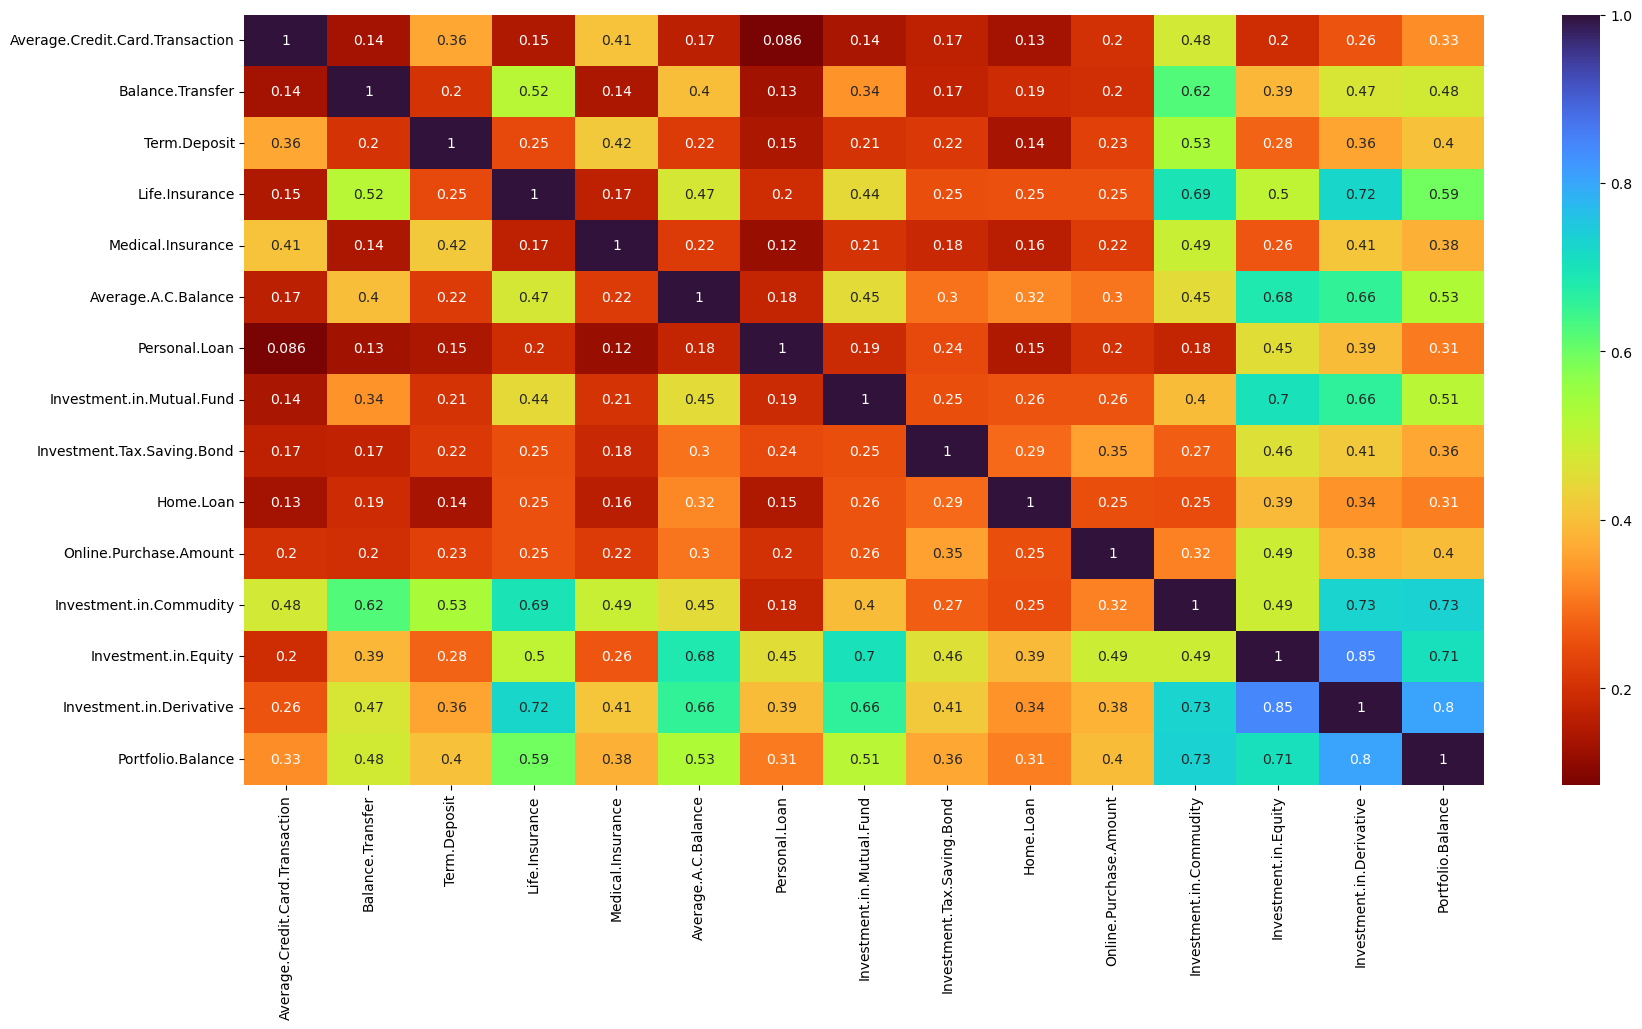

In [ ]:
Bi_Analysis.heatmap()


Observed Independent Variables with High Correlation:-
- Investment in derivative and Investment in Equity: ** 0.85** 
- Portfolio Balance and Investment in Derivative: **0.81**
- Investment in Derivative and Life Insurance: **0.73** 
- Portfolio Balance and Investment in Commodity: **0.74**
- Investment in Equity and Investment in Mutual Fund: **0.7**
- Dataset has significantly high Multi-Collinearity Issues. 


##### Categorical Column

children :-


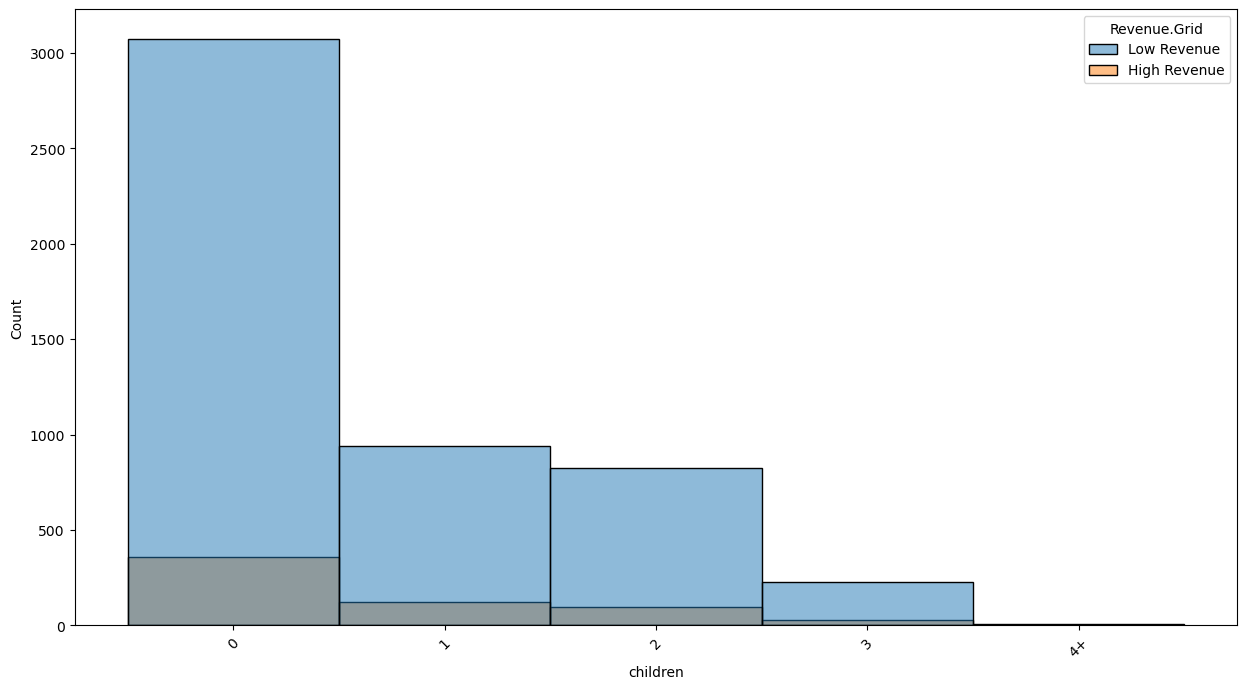

age_band :-


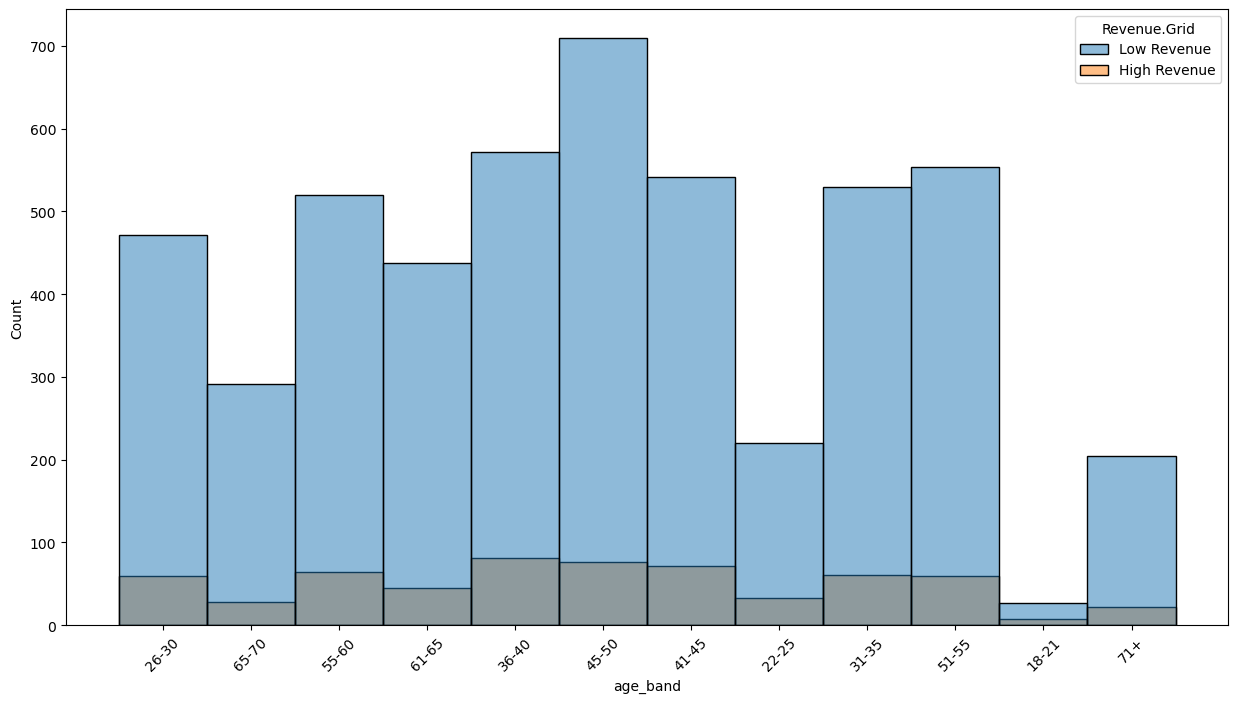

status :-


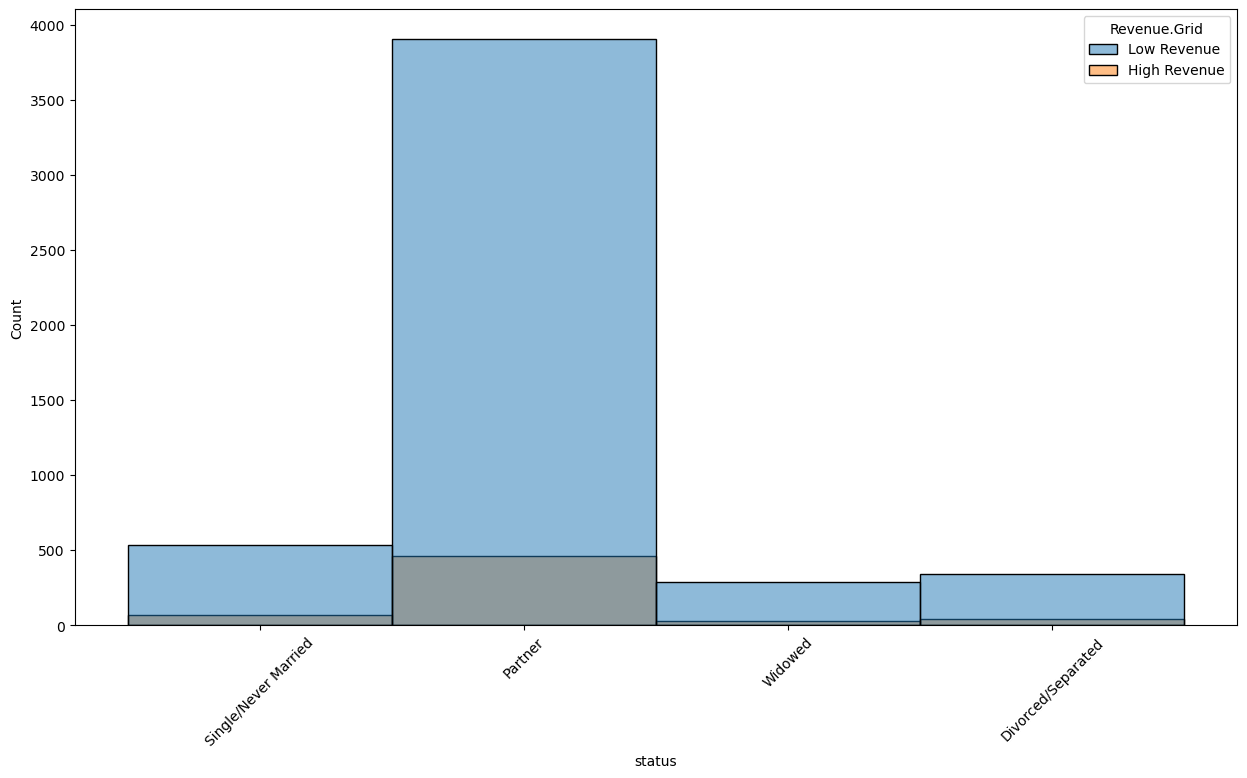

occupation :-


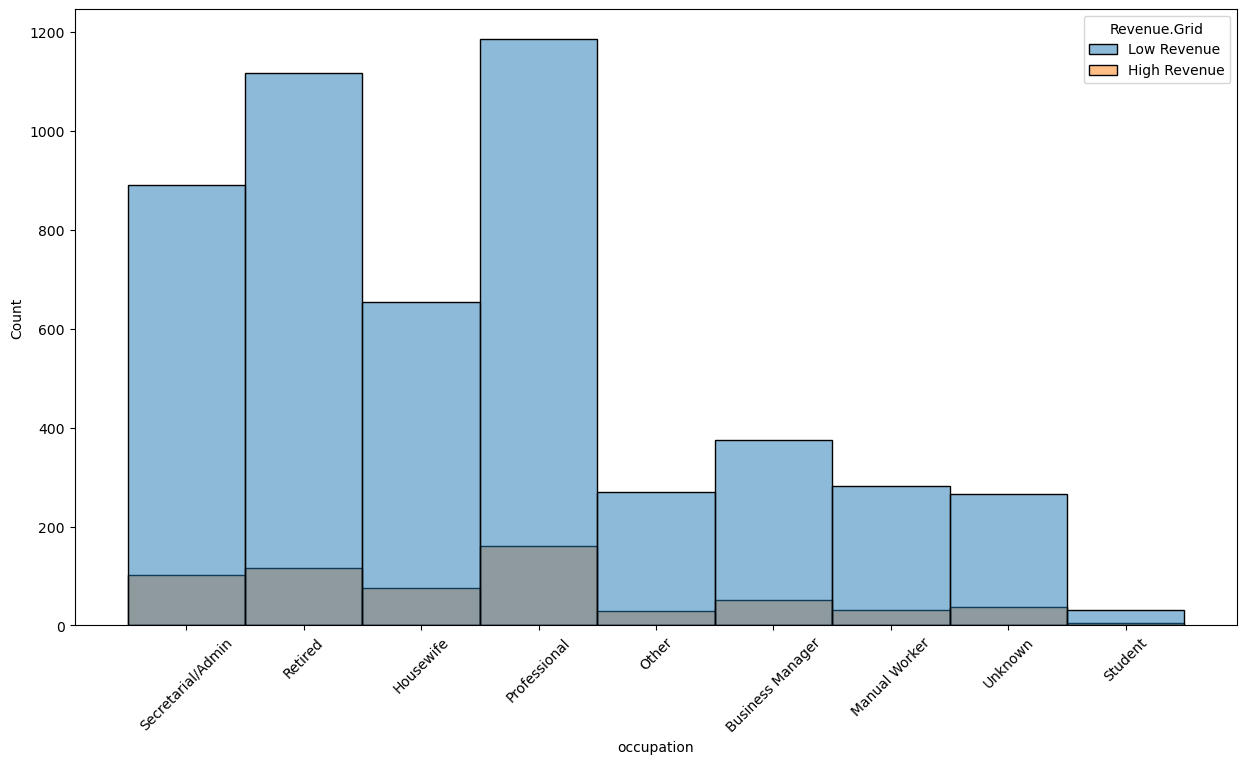

occupation_partner :-


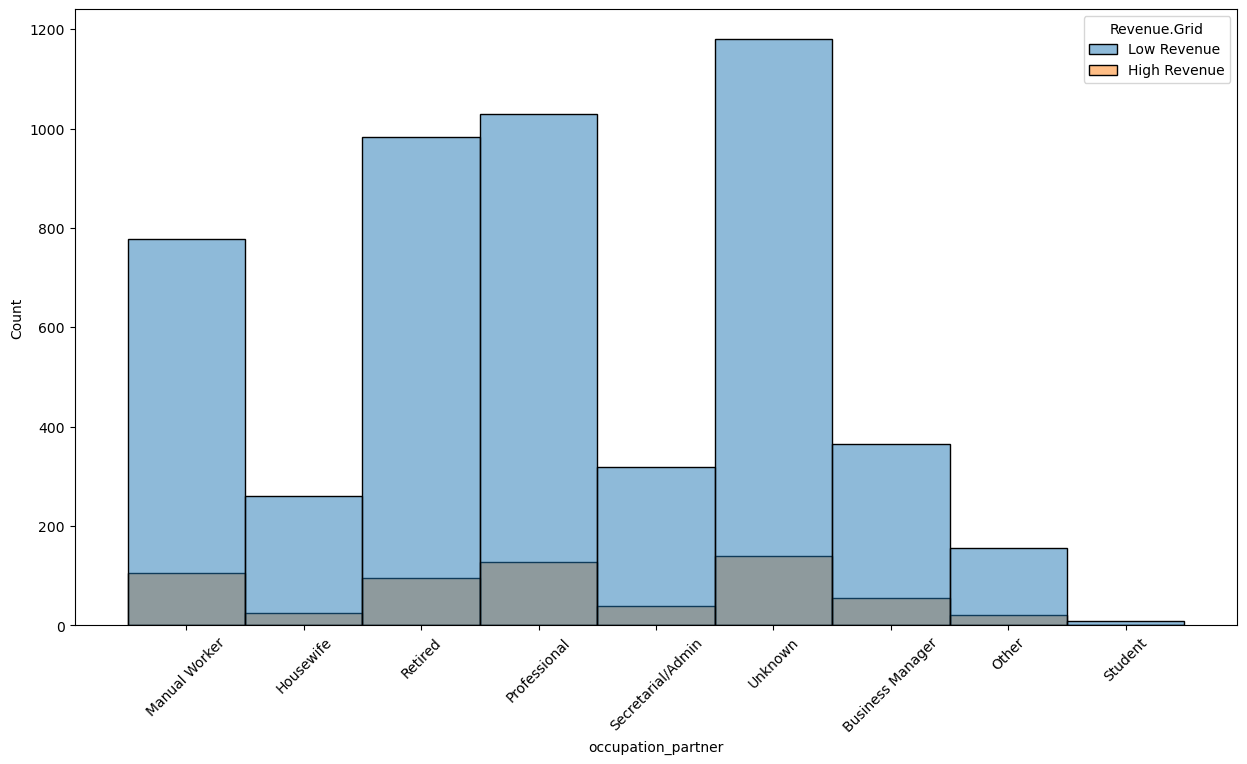

home_status :-


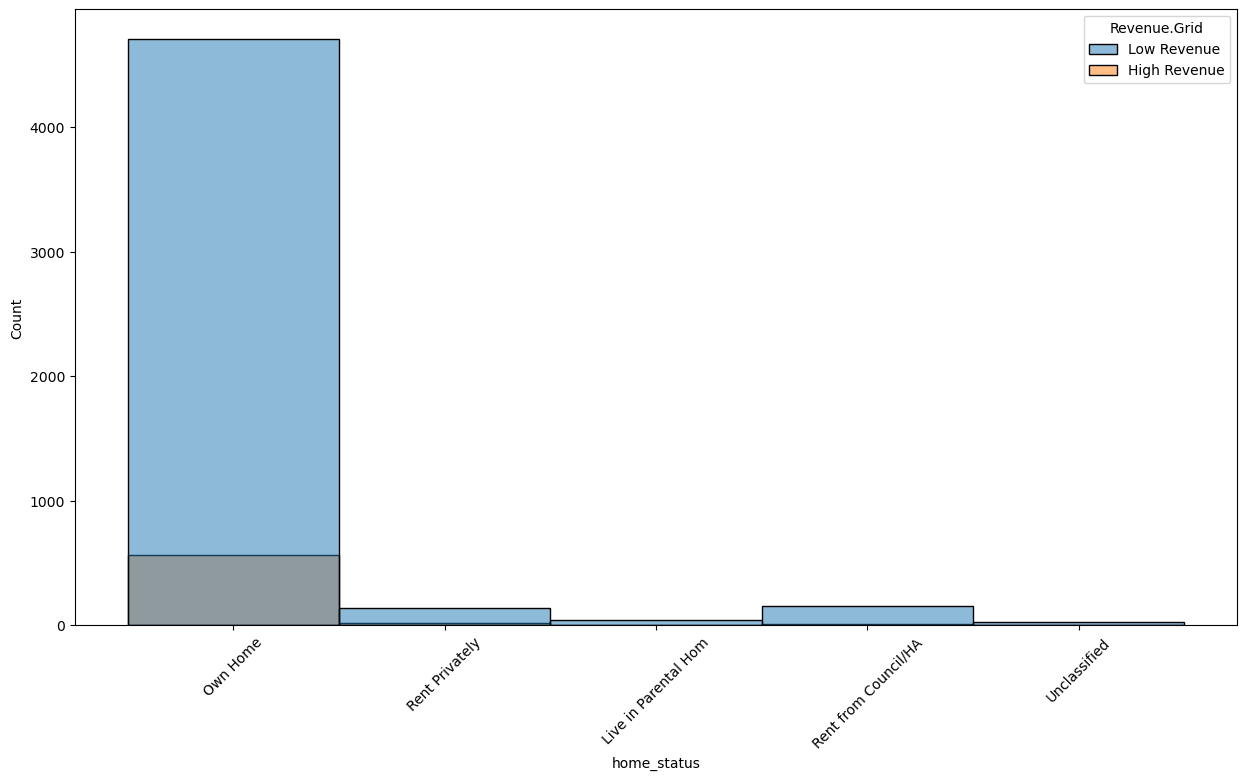

family_income :-


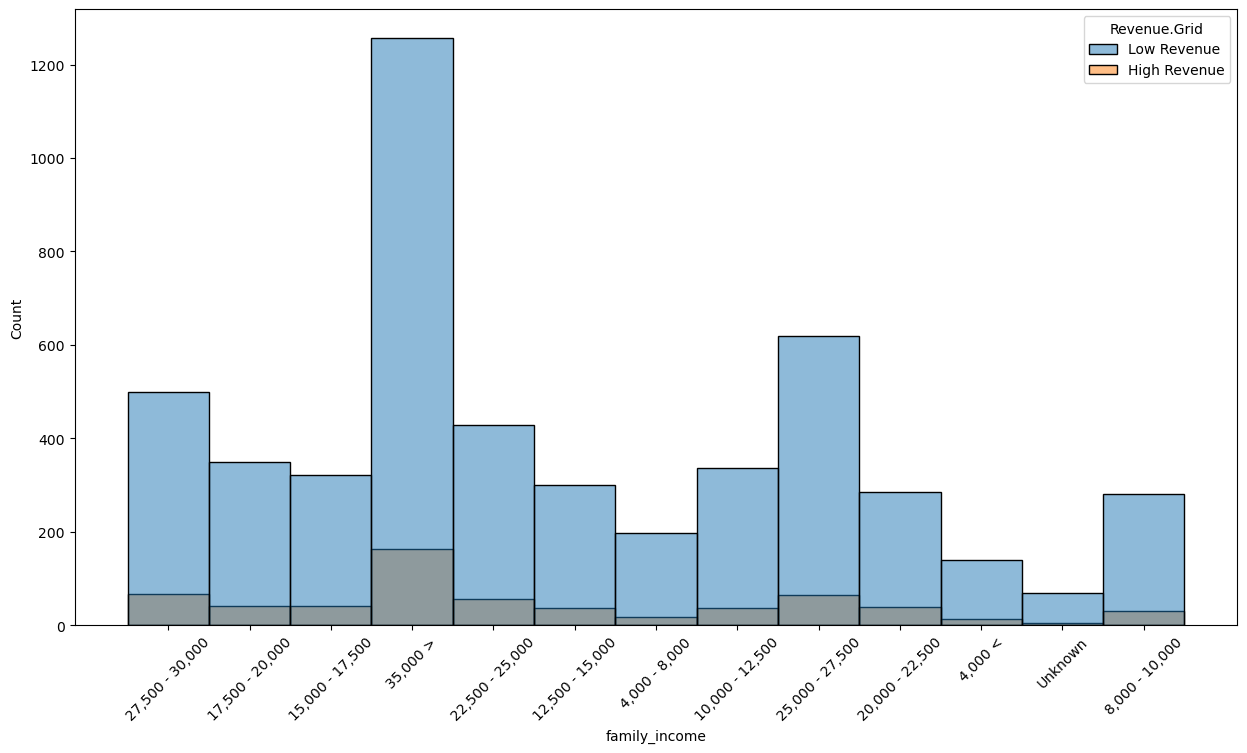

self_employed :-


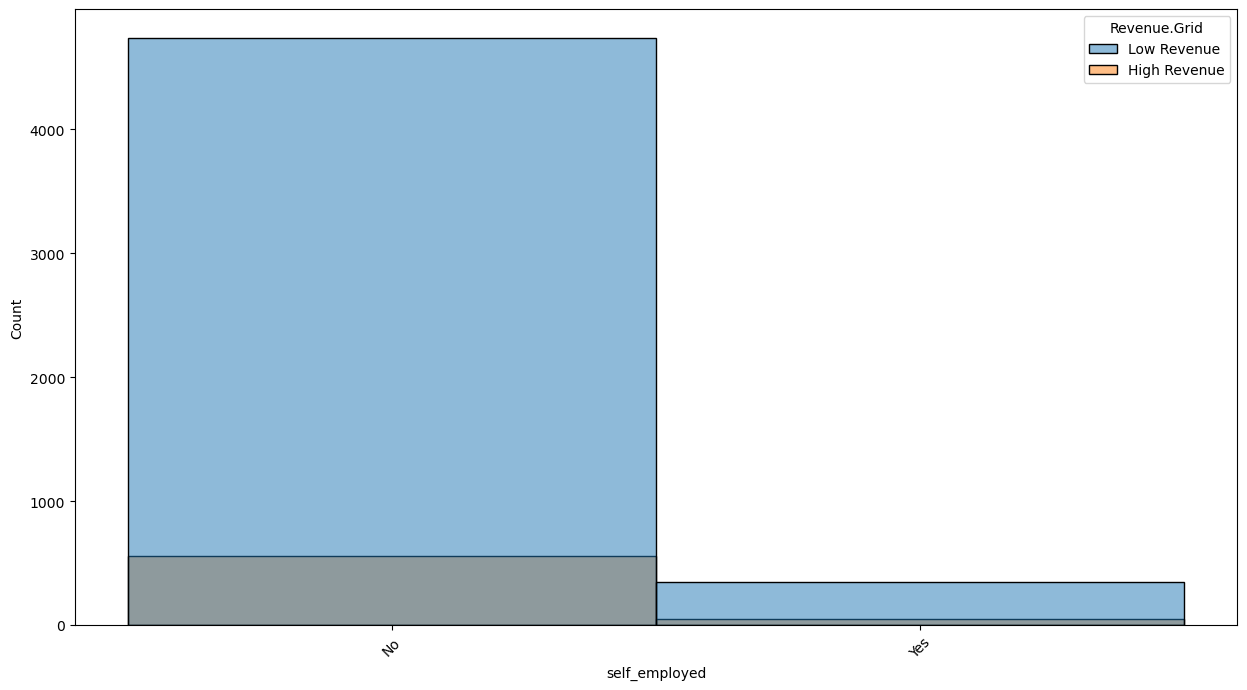

self_employed_partner :-


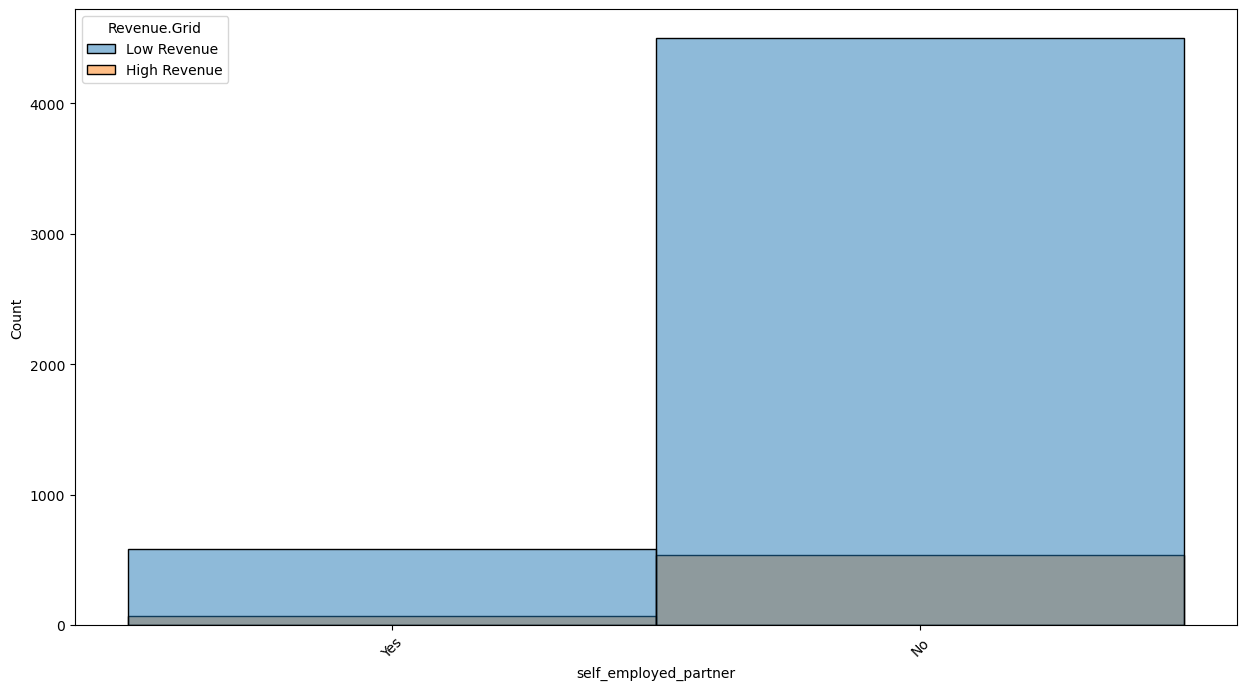

year_last_moved :-


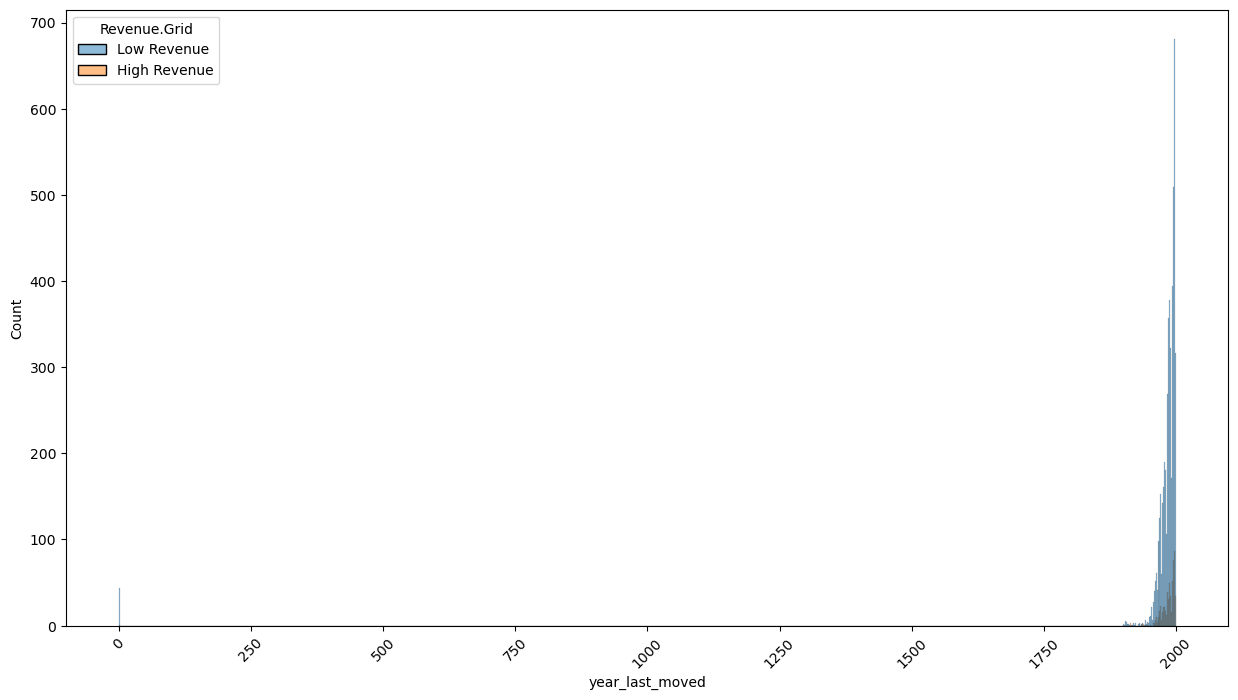

TVarea :-


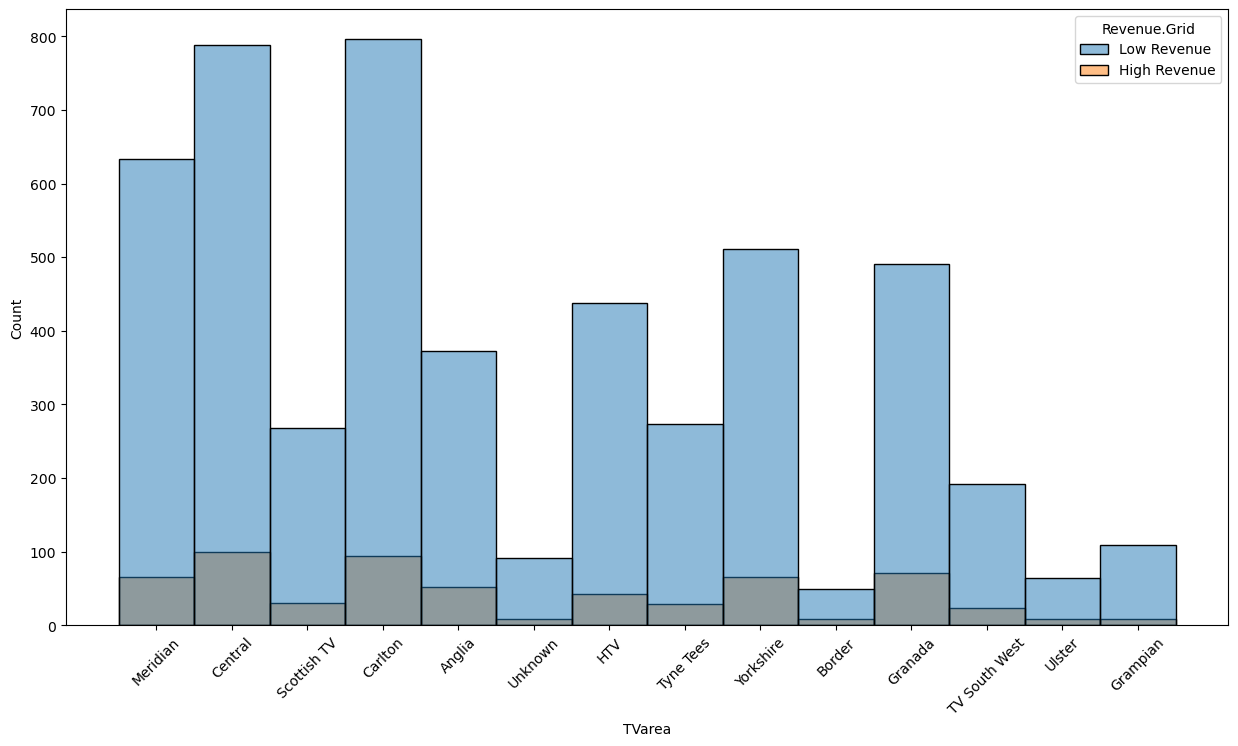

gender :-


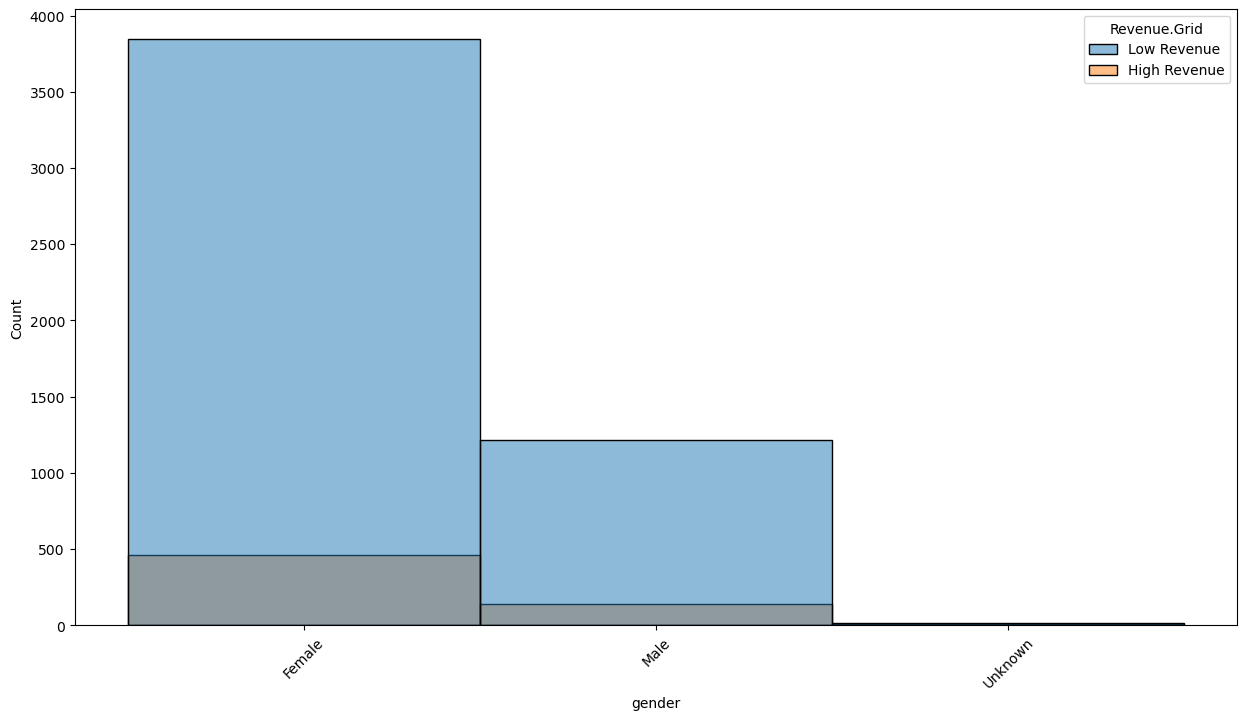

region :-


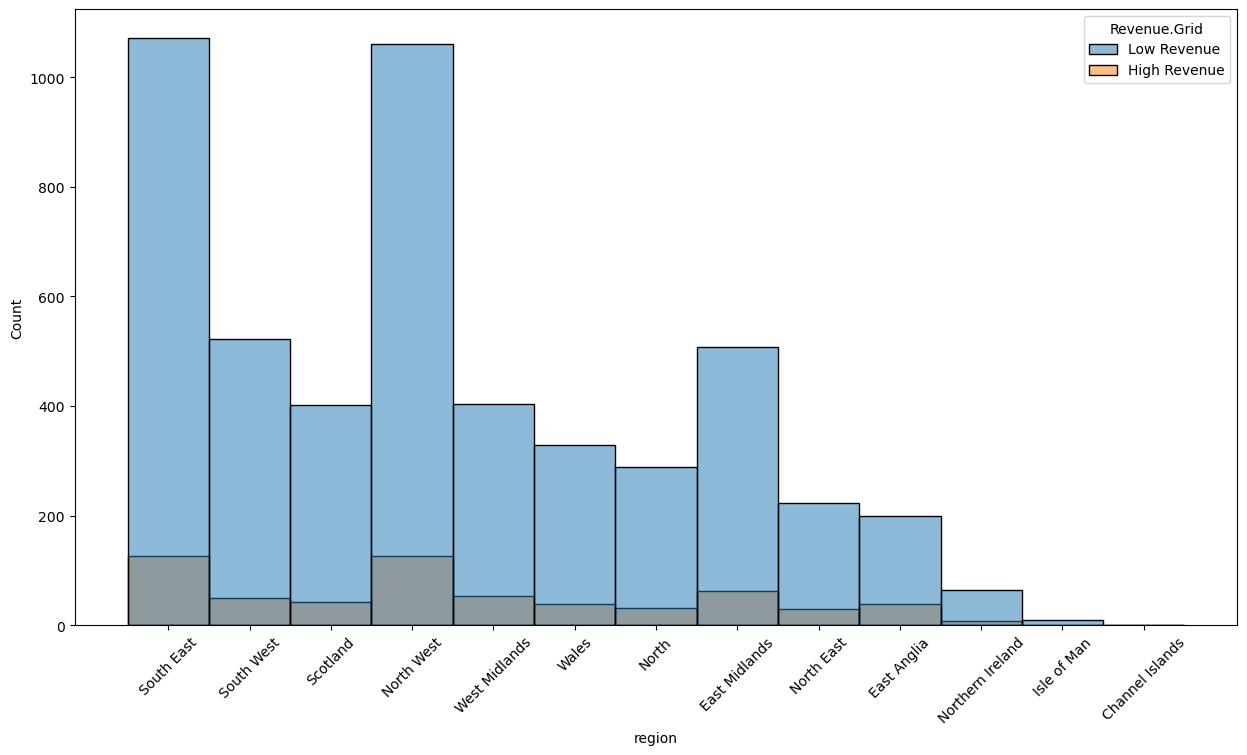

In [ ]:
bar_features = categorical_col.drop(["post_code","post_area"]).copy()
# bar_features = categorical_col.copy()
Bi_Analysis.histplot(bar_features)

##### Continuous Columns

Distribution

Average.Credit.Card.Transaction :-


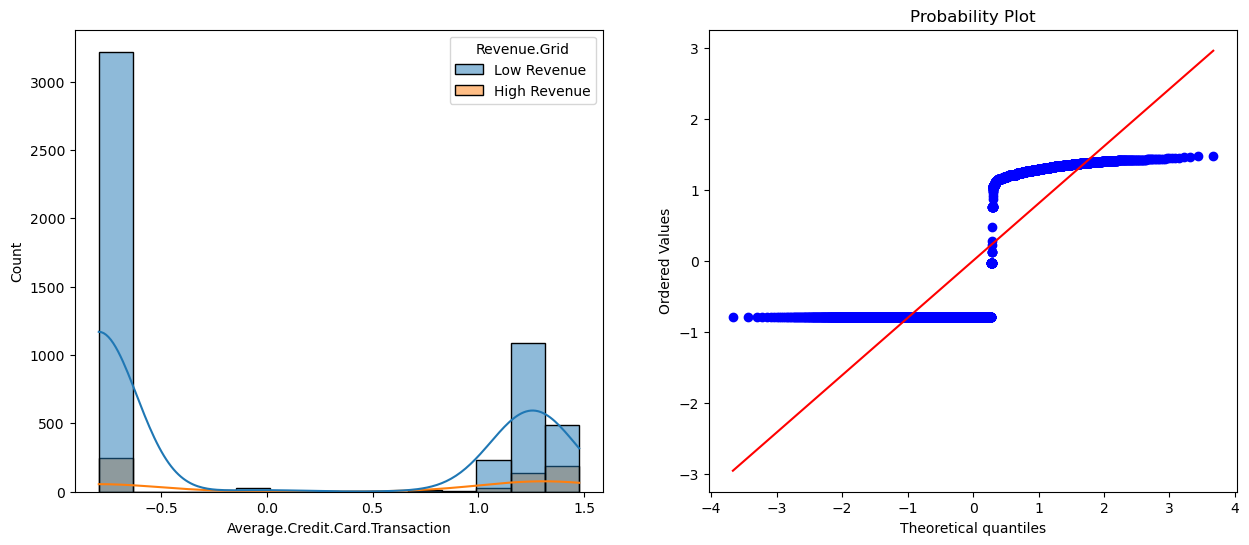

Balance.Transfer :-


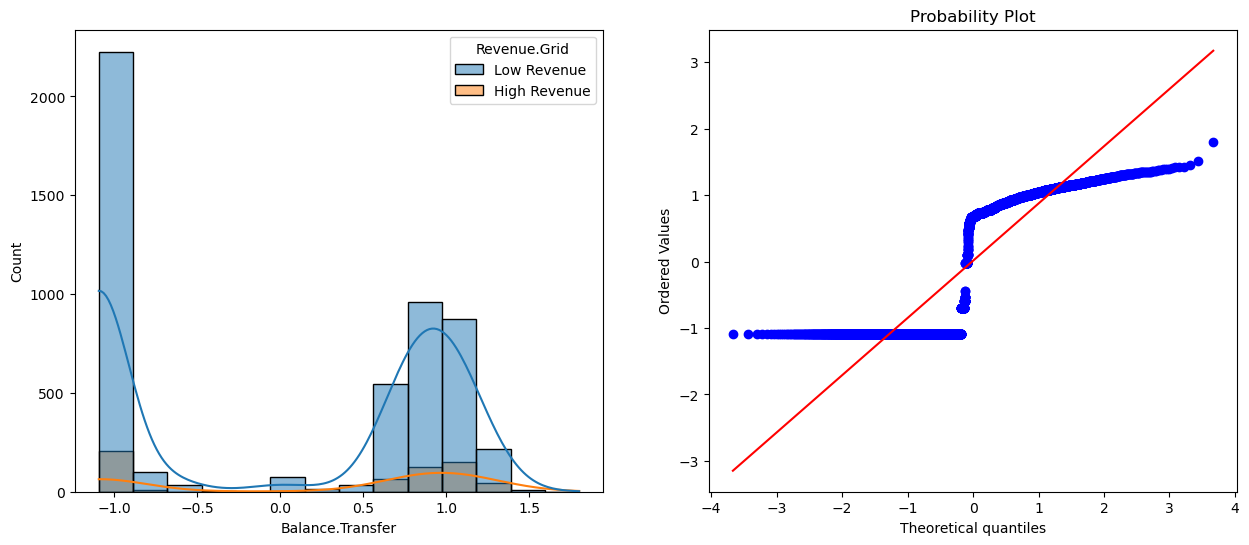

Term.Deposit :-


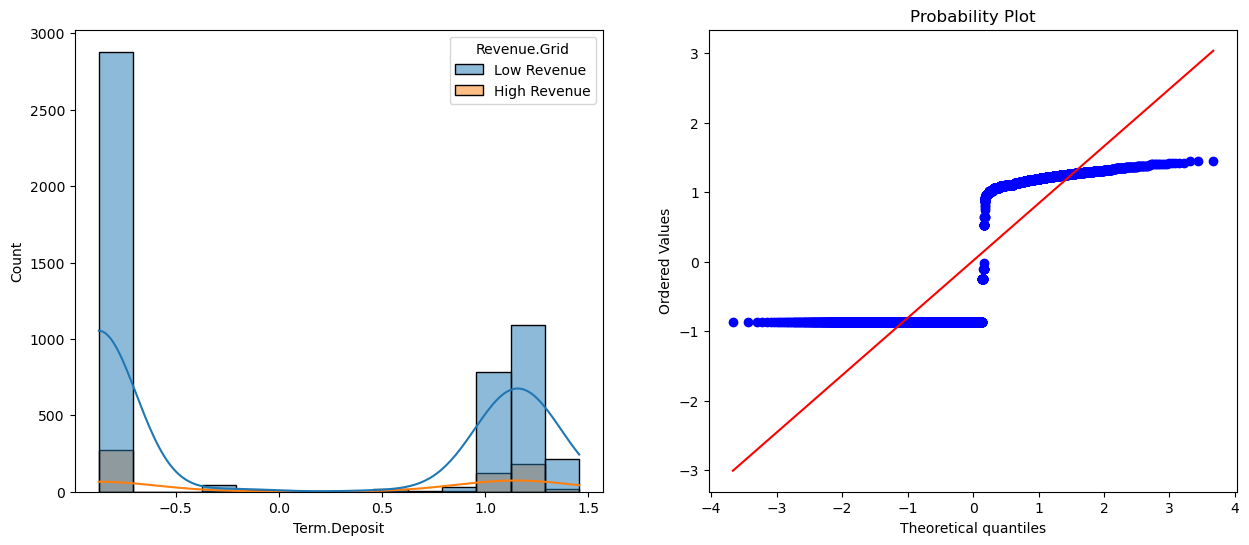

Life.Insurance :-


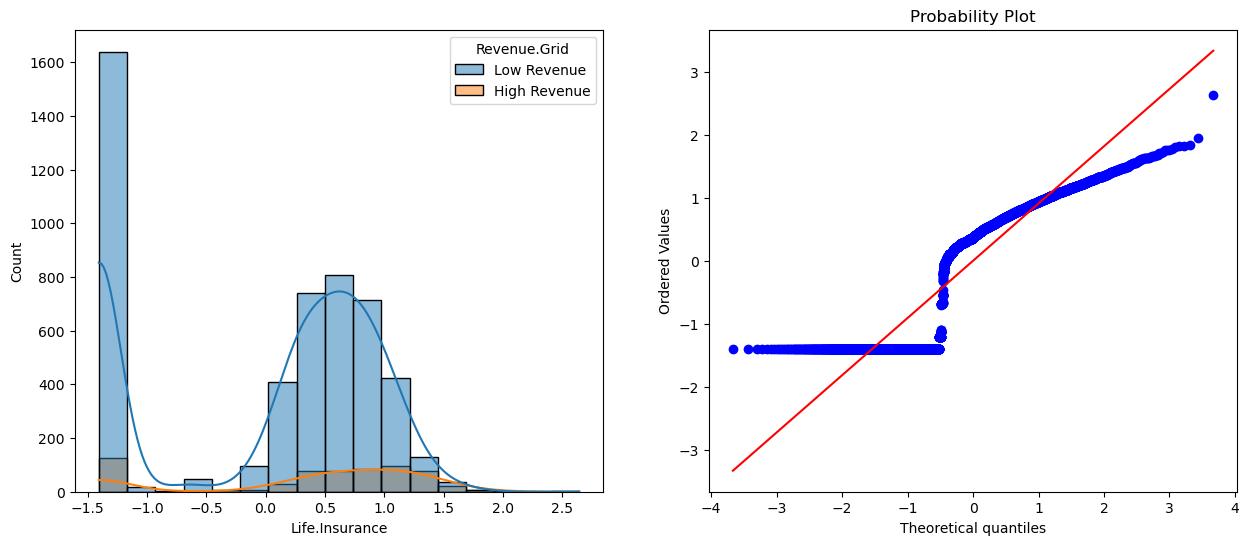

Medical.Insurance :-


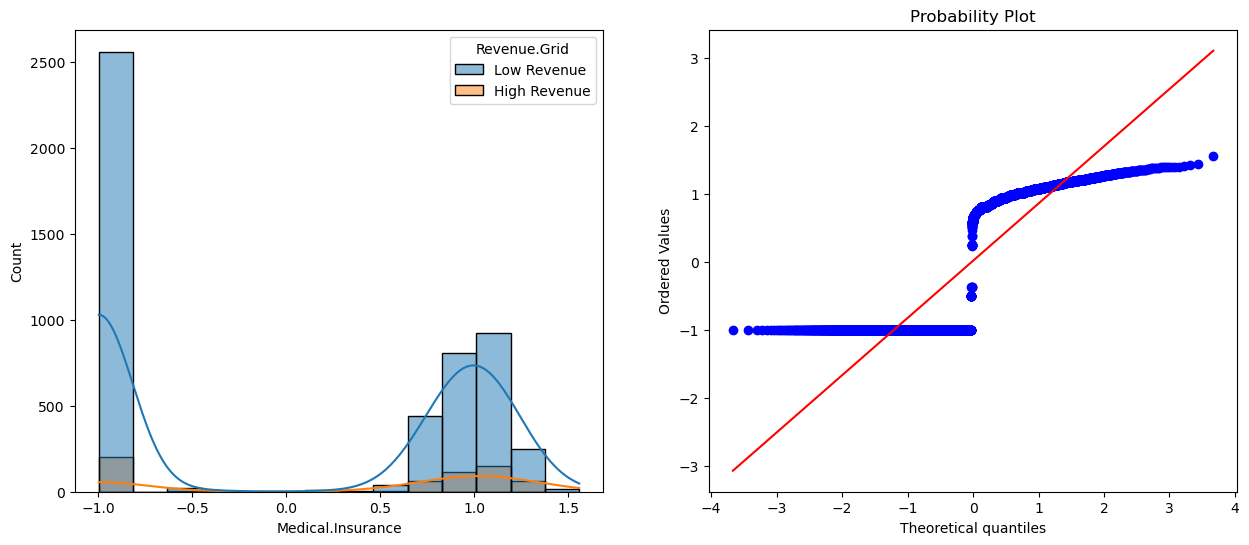

Average.A.C.Balance :-


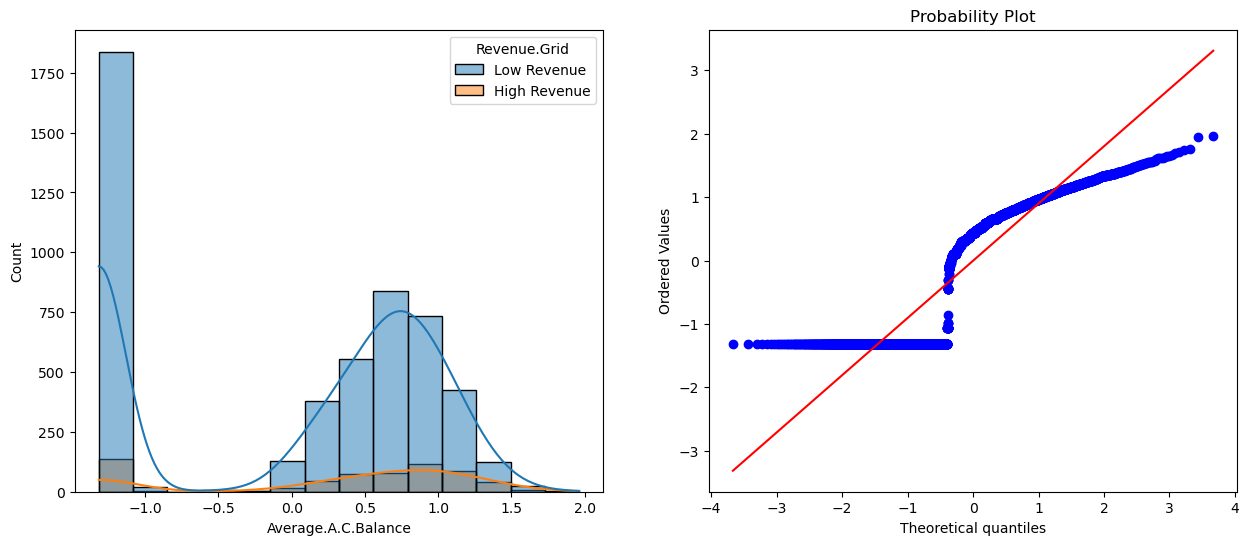

Personal.Loan :-


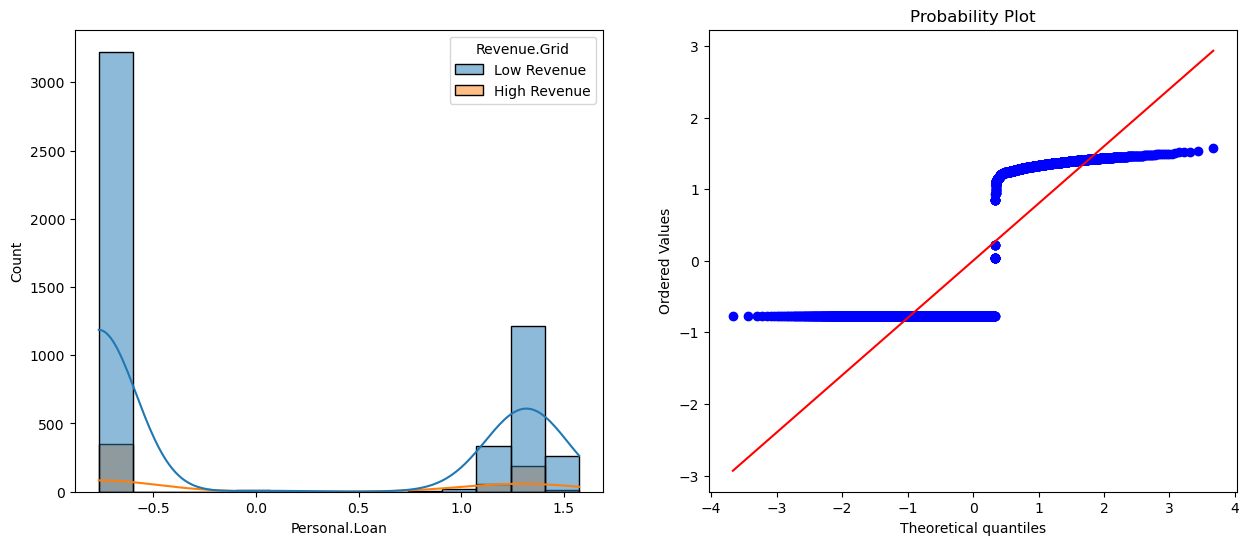

Investment.in.Mutual.Fund :-


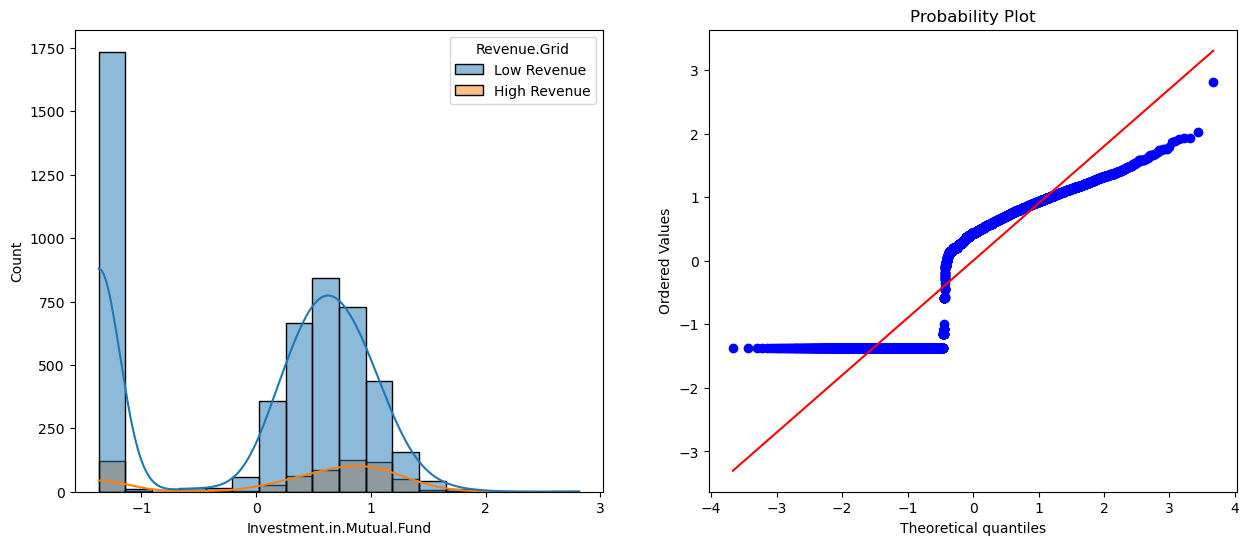

Investment.Tax.Saving.Bond :-


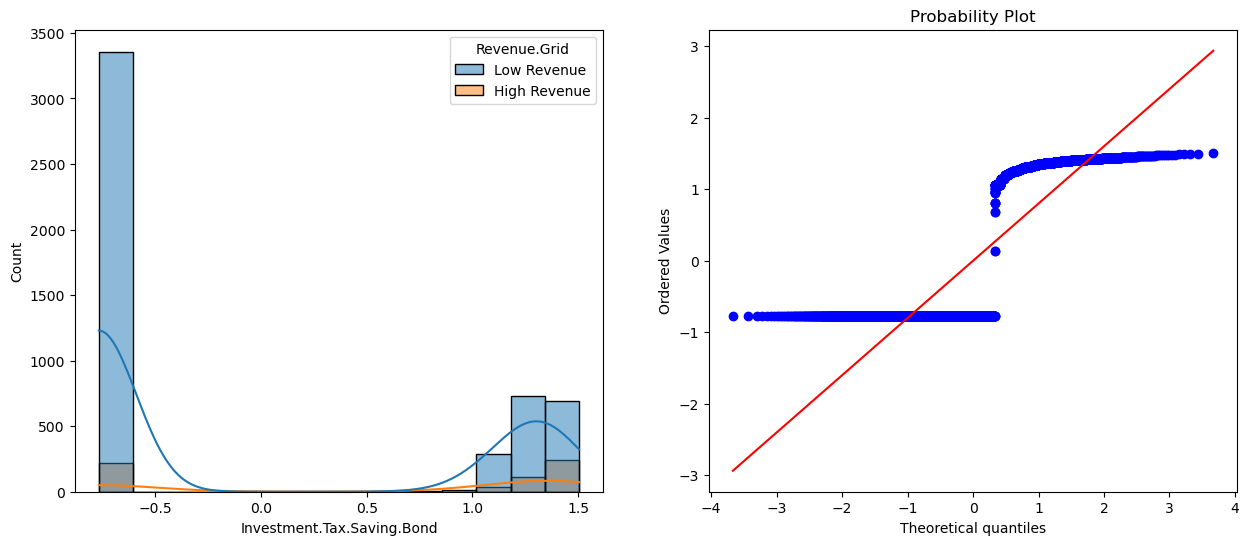

Home.Loan :-


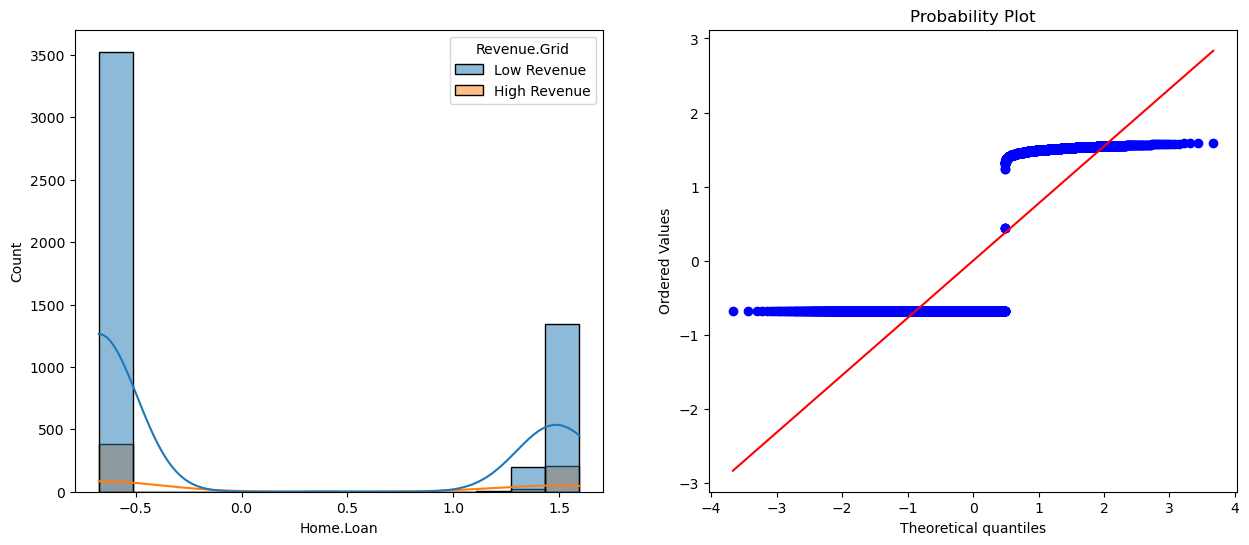

Online.Purchase.Amount :-


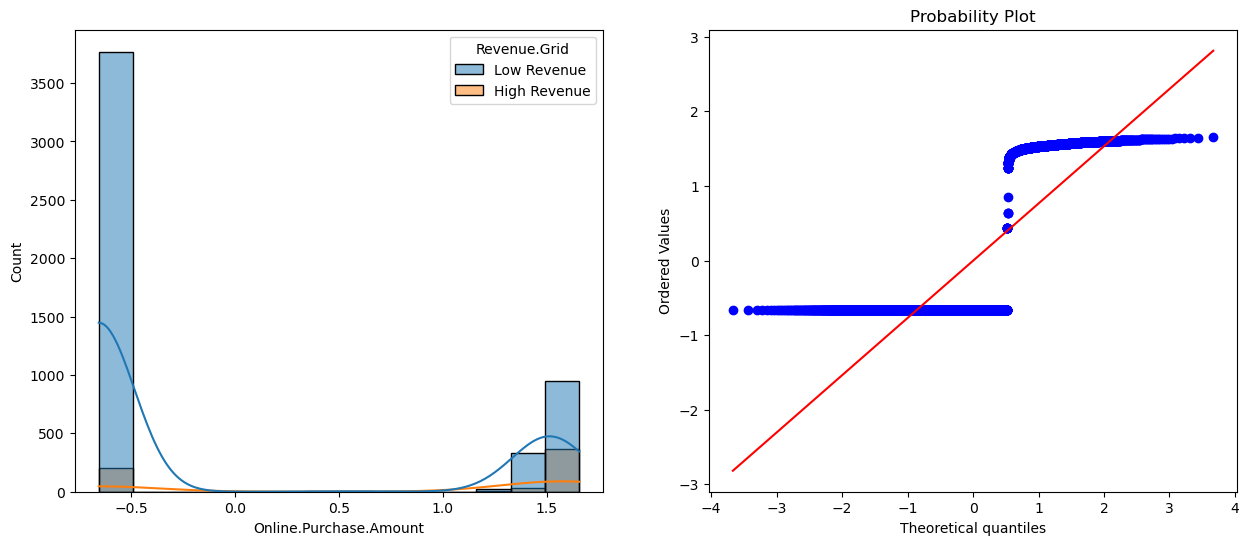

Investment.in.Commudity :-


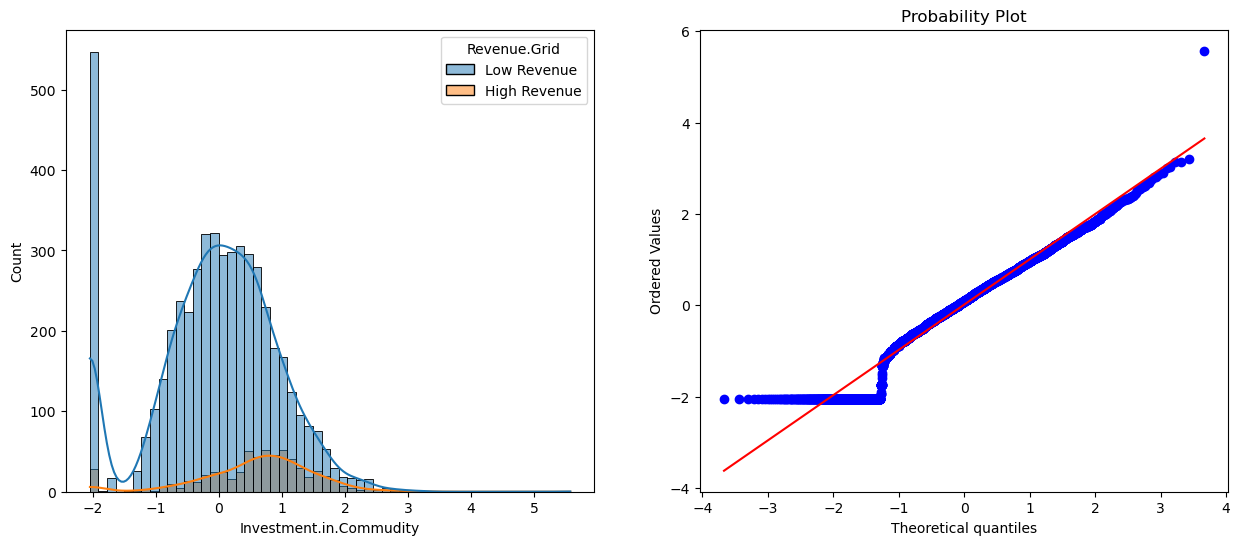

Investment.in.Equity :-


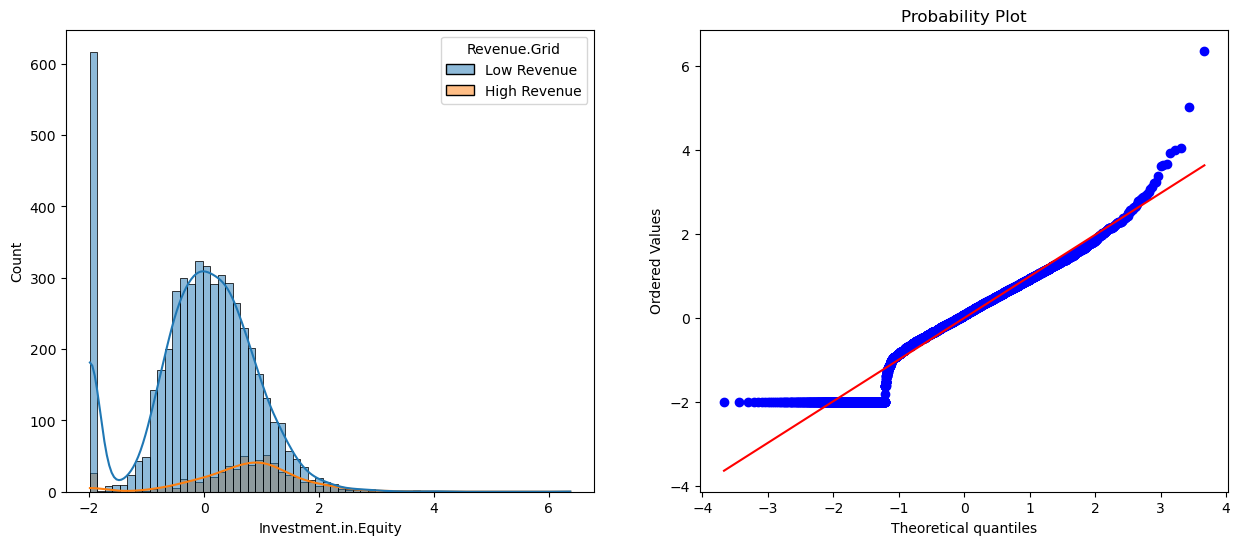

Investment.in.Derivative :-


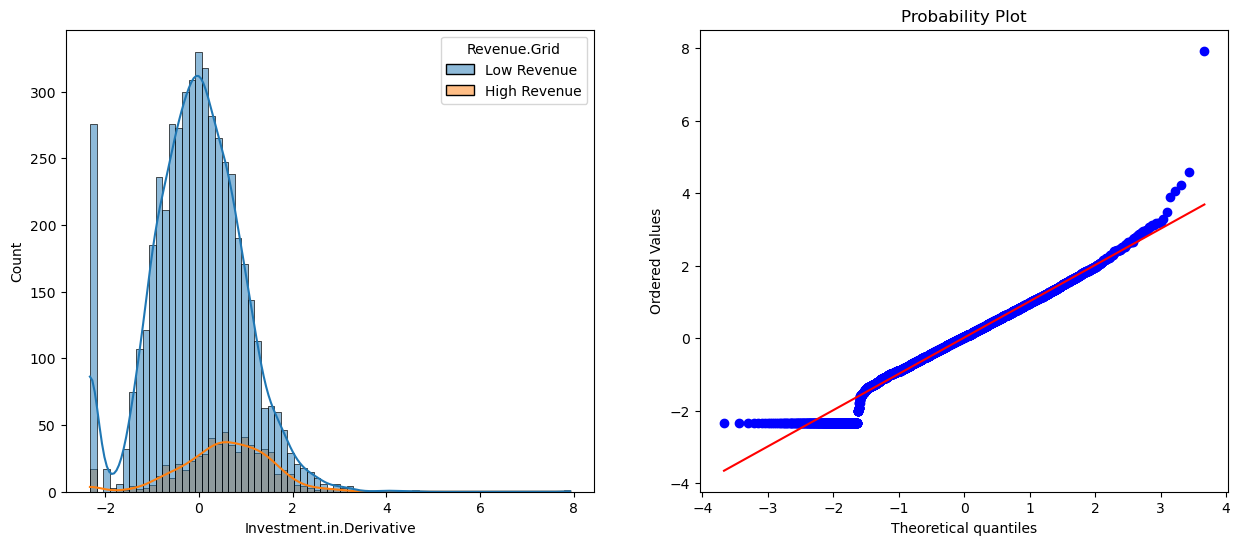

Portfolio.Balance :-


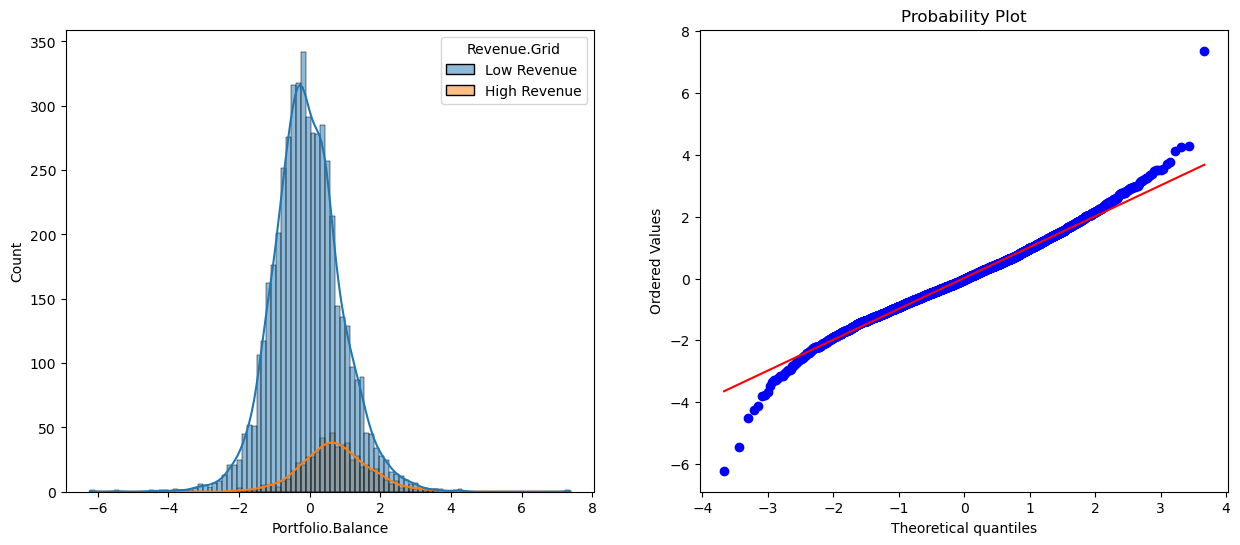

In [ ]:
Bi_Analysis.histplot_continuous(continuous_cols)

Relatiosnhip

Average.Credit.Card.Transaction :-


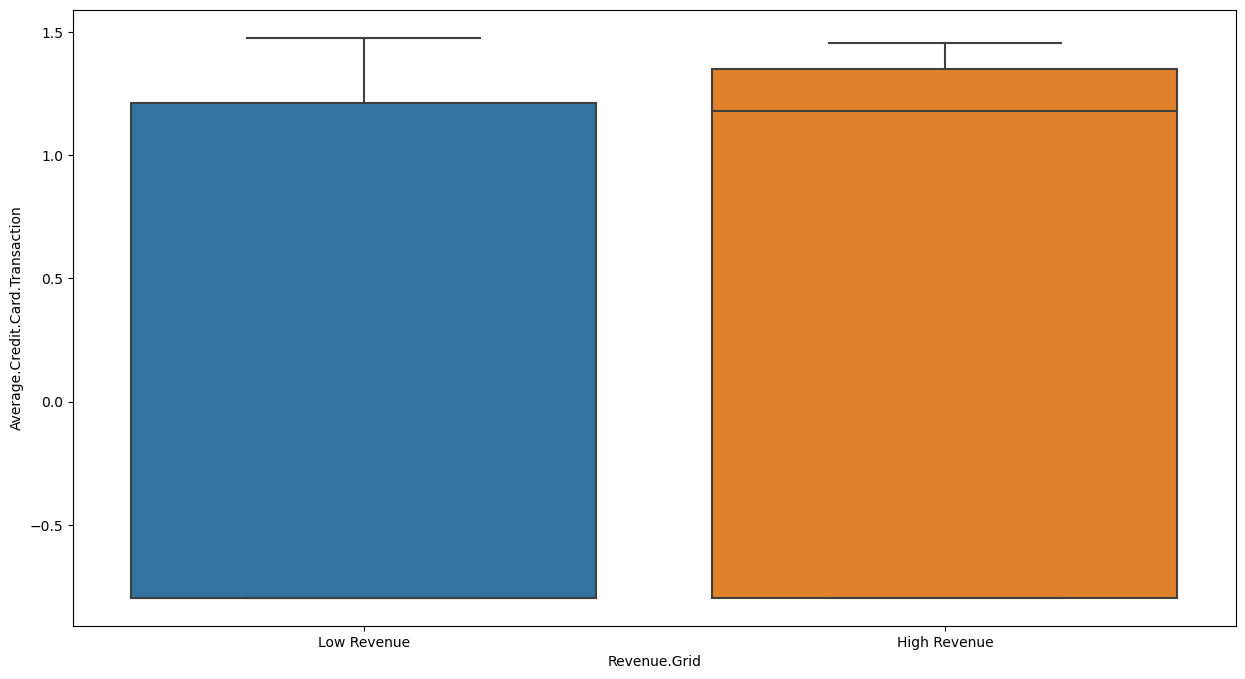

Balance.Transfer :-


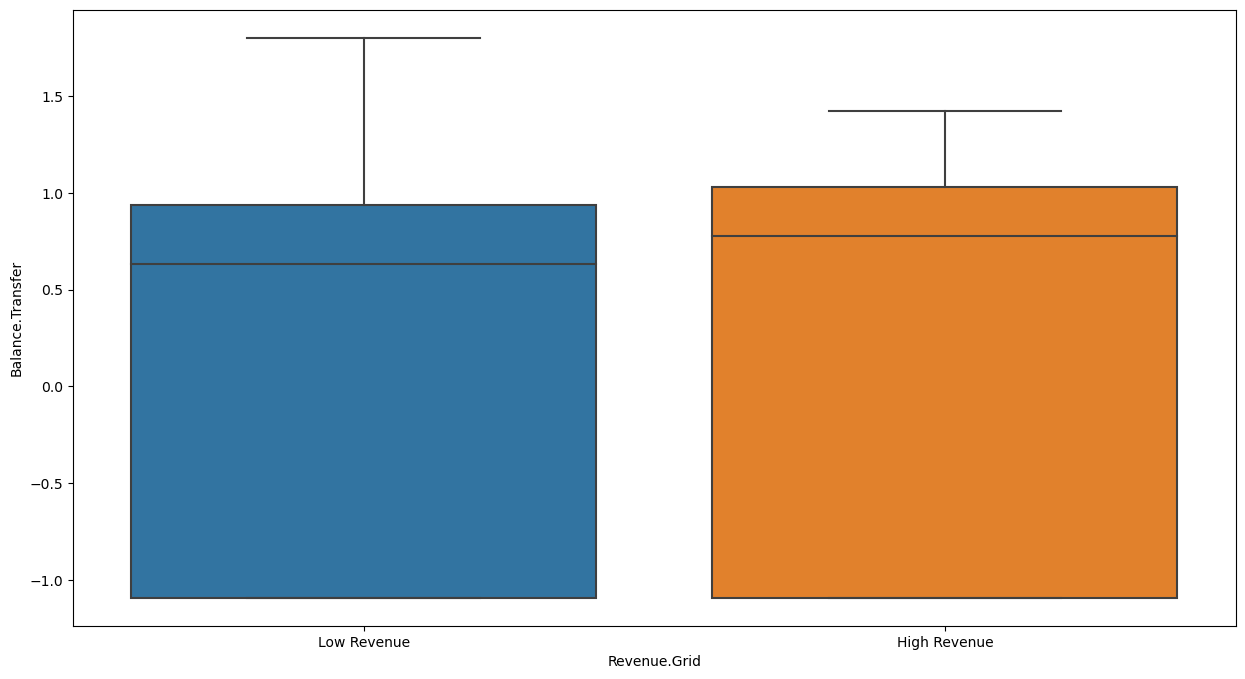

Term.Deposit :-


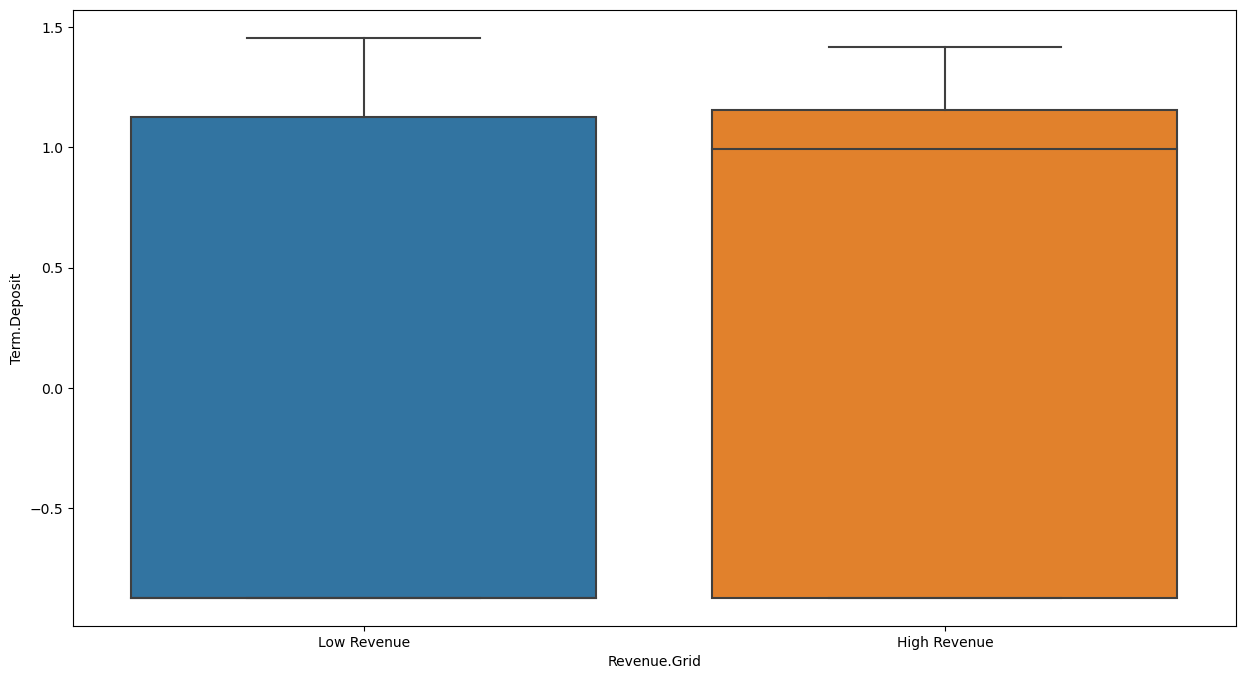

Life.Insurance :-


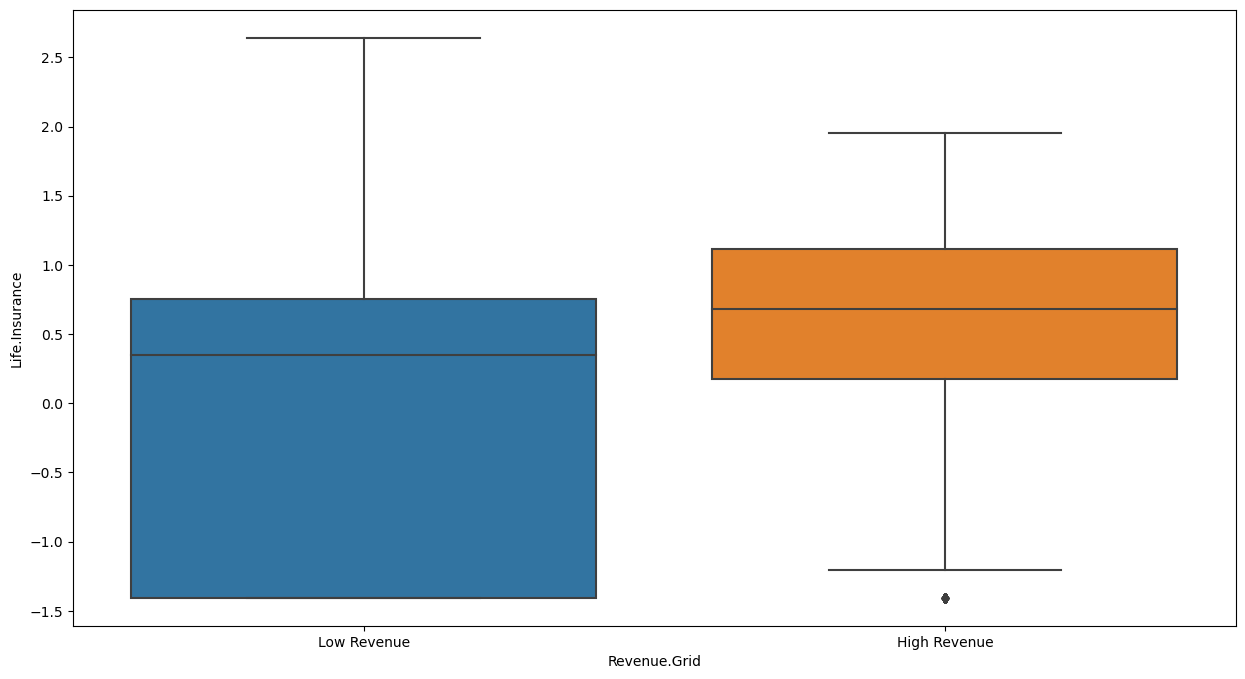

Medical.Insurance :-


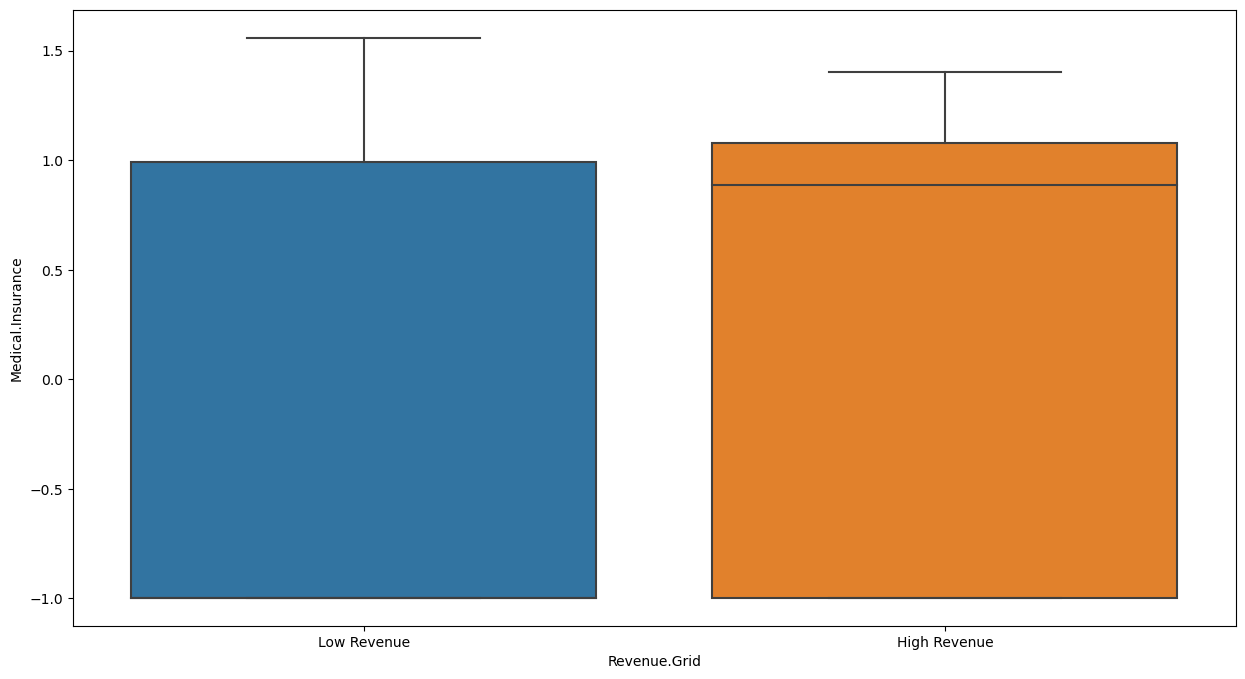

Average.A.C.Balance :-


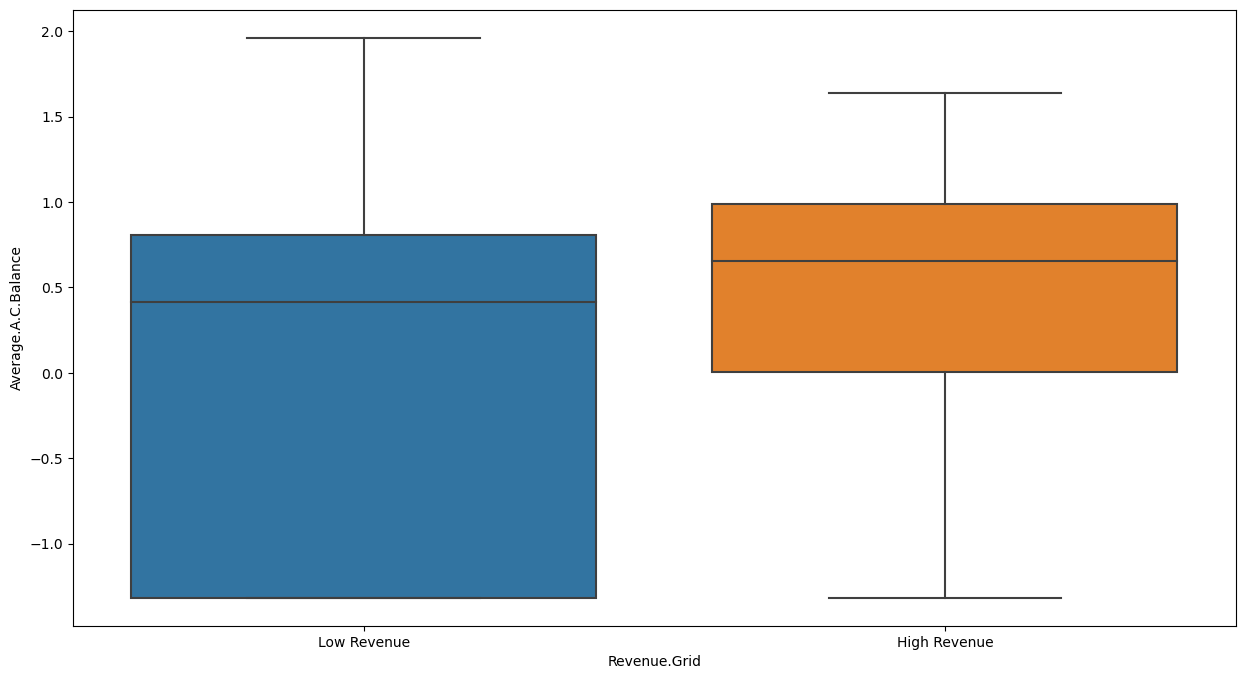

Personal.Loan :-


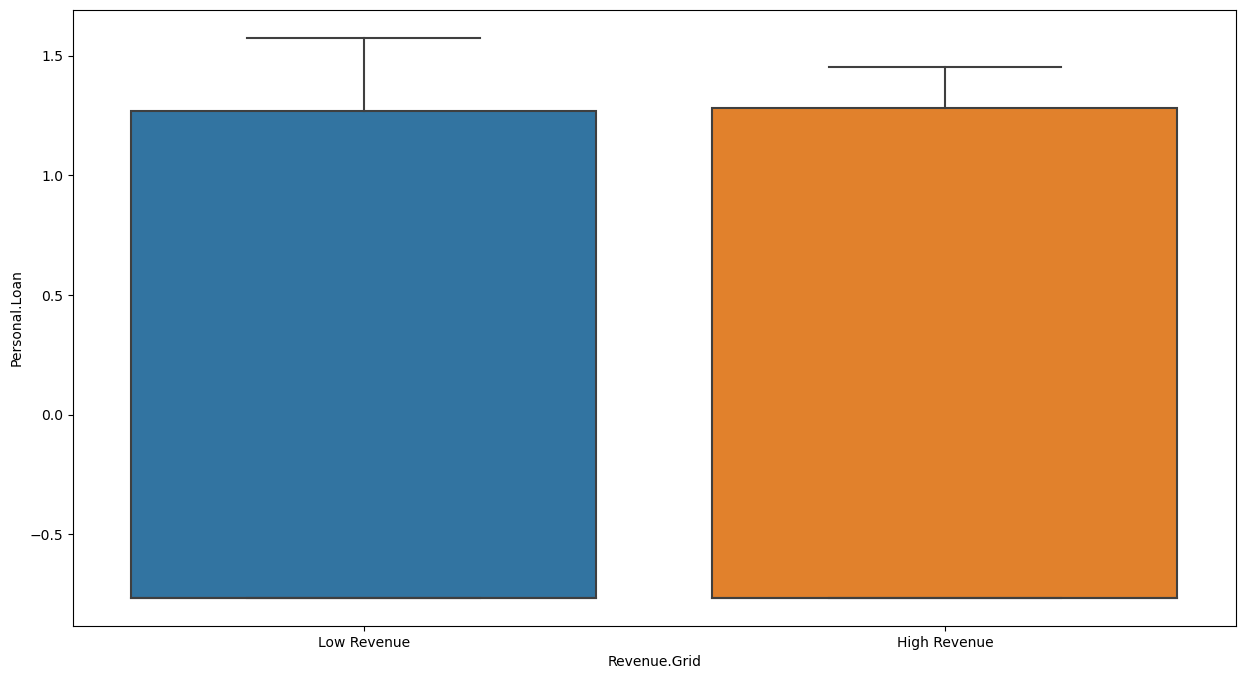

Investment.in.Mutual.Fund :-


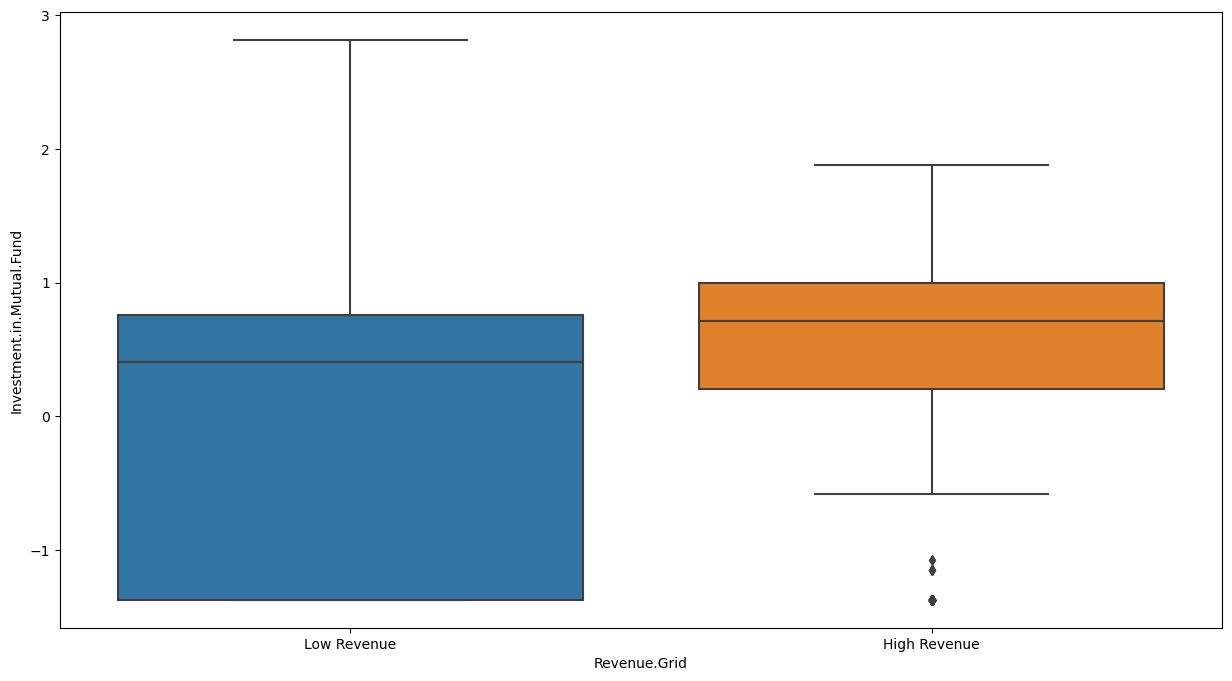

Investment.Tax.Saving.Bond :-


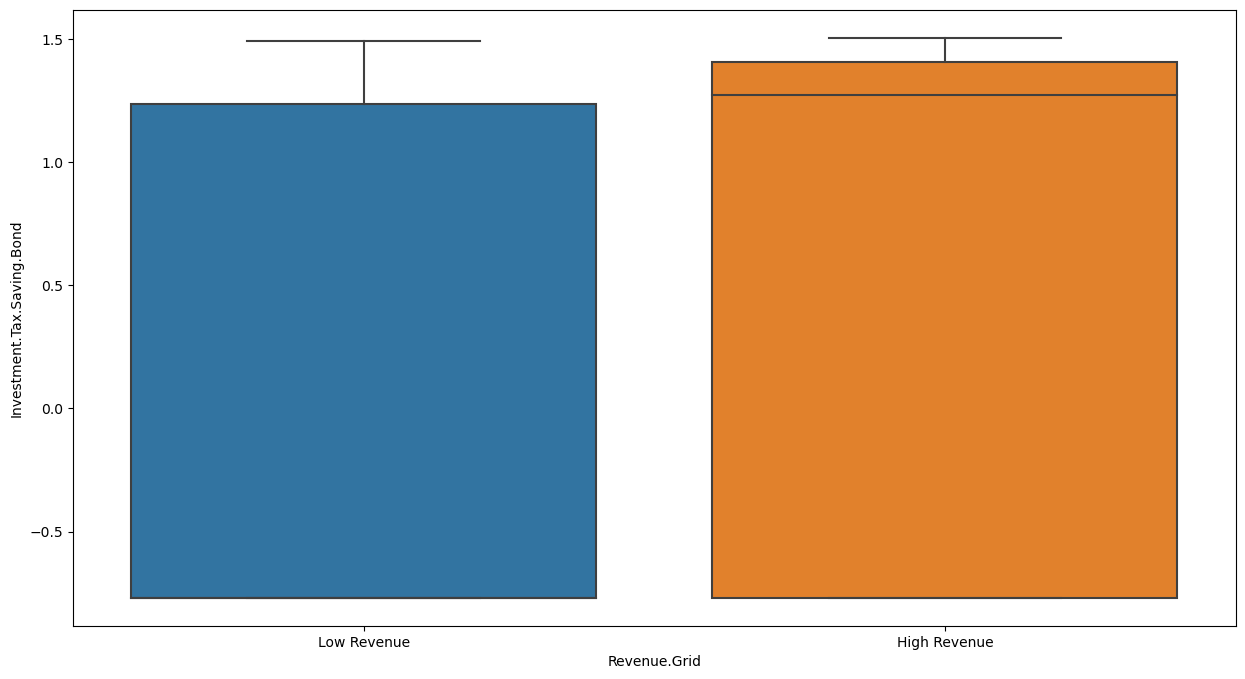

Home.Loan :-


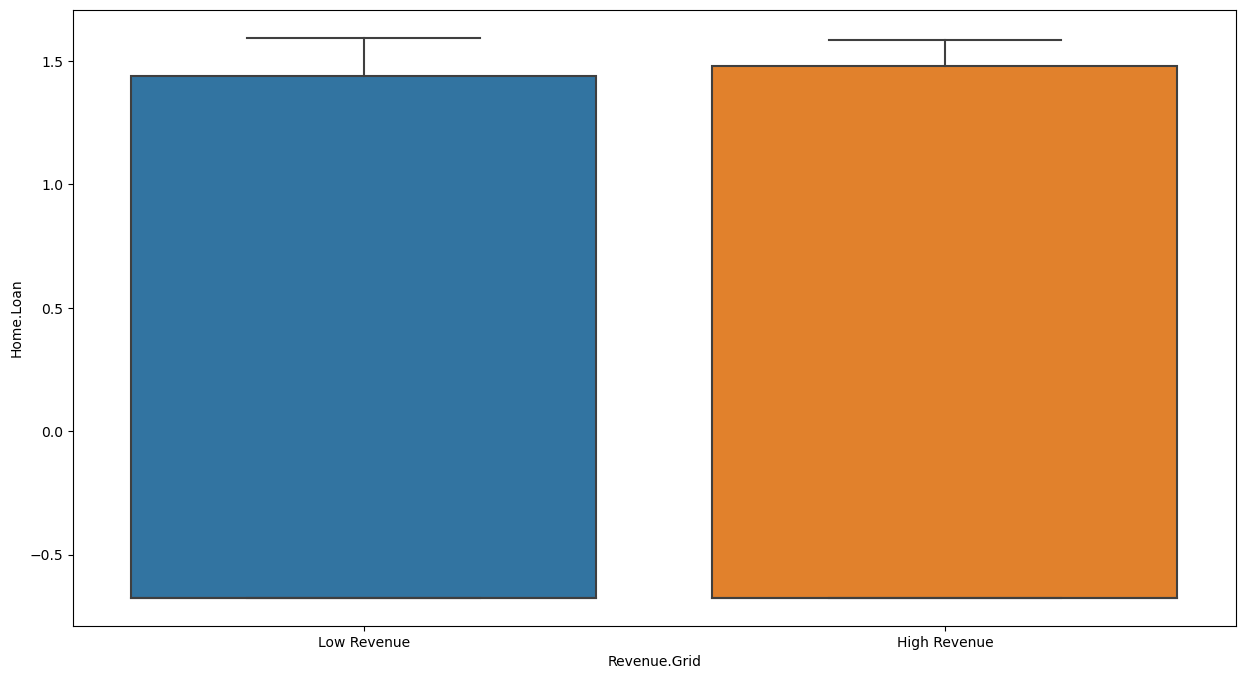

Online.Purchase.Amount :-


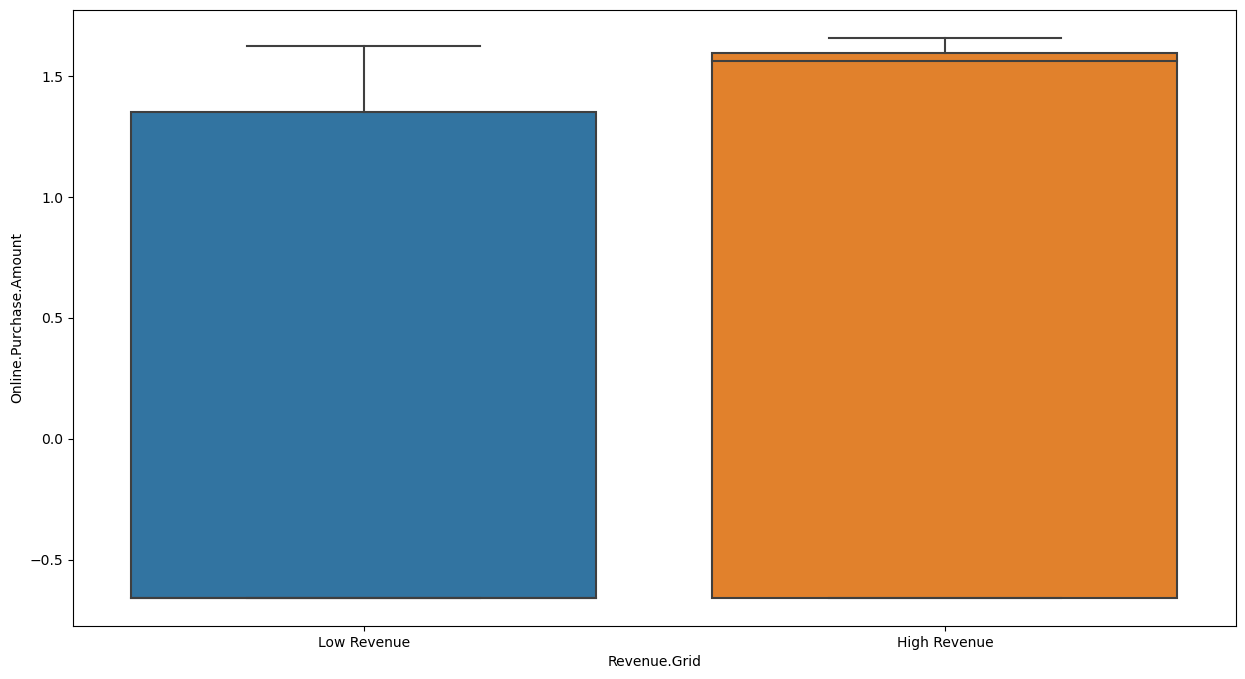

Investment.in.Commudity :-


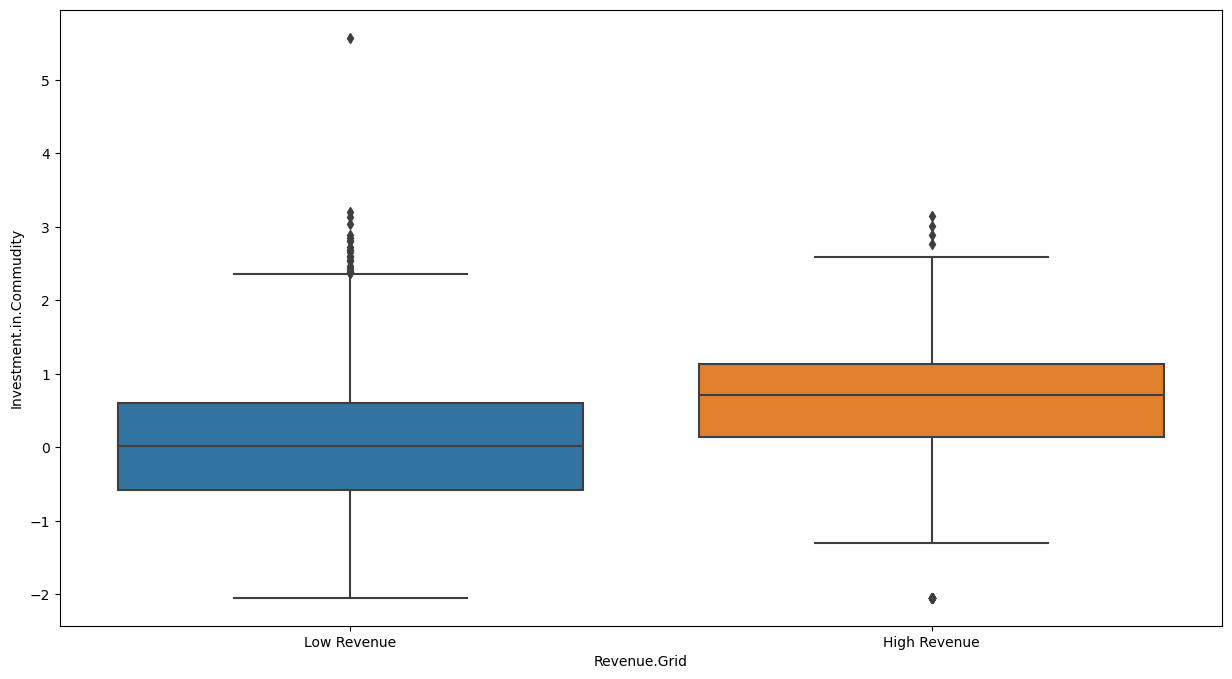

Investment.in.Equity :-


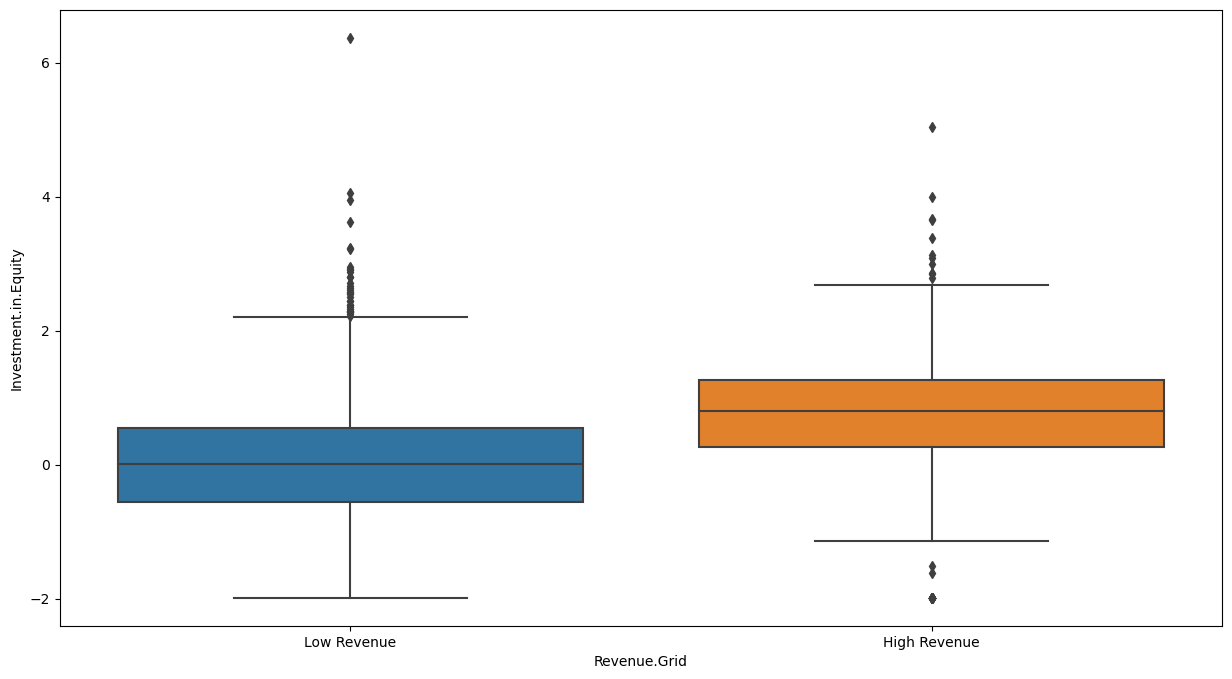

Investment.in.Derivative :-


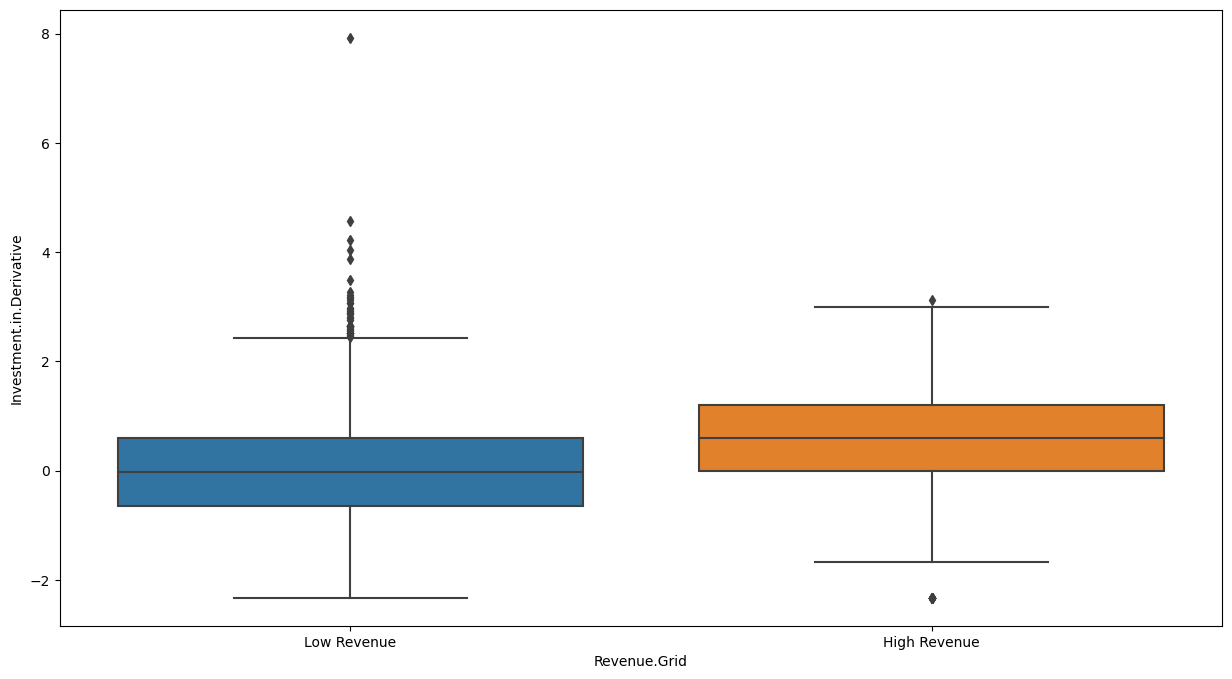

Portfolio.Balance :-


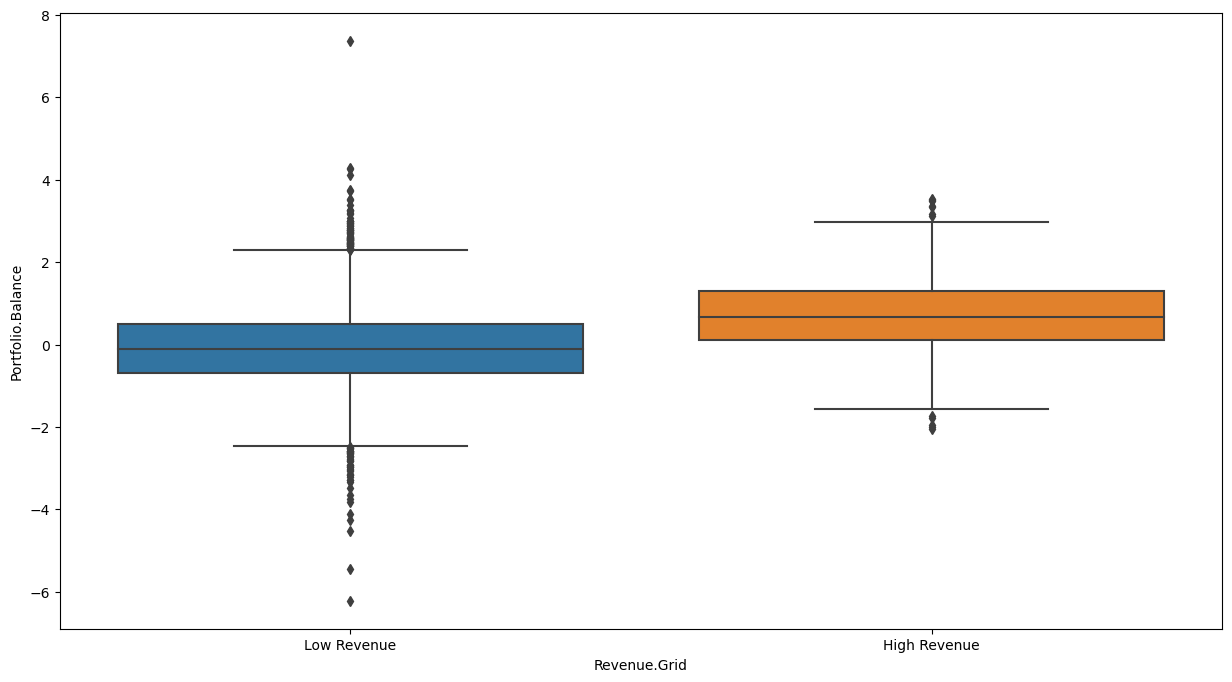

In [ ]:
Bi_Analysis.boxplot(continuous_cols)

### Data Cleaning

##### Dropping Identifier Column

In [73]:
M1.drop_identifier()

#### Imputation

In [74]:
M1.imputer()

#### Encoding

In [75]:
M1.encode()

#### Feature Construction

In [76]:
M1.feature_construction()

#### Transform

In [77]:
M1.transform('box-cox')

#### Outliers

In [78]:
# M1.outlier()

#### Dummies

In [79]:
M1.dummies()

#### Scaling

In [80]:
M1.scaling()

#### Feature Selection

In [81]:
M1.feature_selection(0.005)

Selected features:-
['post_code', 'post_area', 'Average.Credit.Card.Transaction', 'Balance.Transfer', 'Term.Deposit', 'Life.Insurance', 'Medical.Insurance', 'Average.A.C.Balance', 'Personal.Loan', 'Investment.in.Mutual.Fund', 'Investment.Tax.Saving.Bond', 'Online.Purchase.Amount', 'Investment.in.Commudity', 'Investment.in.Equity', 'Investment.in.Derivative', 'Portfolio.Balance', 'Investment_Portfolio', 'Total_Debt', 'Investment_Debt_Ratio']


## Model Development

### Classic Models

#### Logistic Regression

In [94]:
# Data Initializatiion
LR = Model(train_size=train_size)

# Data Pre-Processing
LR.drop_identifier()
LR.imputer()
LR.encode(preference=0)
LR.feature_construction()
LR.transform()
LR.dummies()
LR.add_constant()
LR.pca()
LR.vif()
LR.feature_selection()

# Model Building
LR.logistic_regression()
compare_df = LR.evaluate()

High VIF Features: 
['Investment.in.Commudity', 'Home.Loan', 'PCA1', 'Investment_Portfolio', 'Investment.in.Derivative', 'Investment.in.Equity', 'Total_Debt', 'PCA2', 'year_last_moved', 'Portfolio.Balance', 'occupation', 'home_status', 'self_employed']
Selected features:-
['children', 'occupation_partner', 'family_income', 'Average.Credit.Card.Transaction', 'Balance.Transfer', 'Term.Deposit', 'Life.Insurance', 'Medical.Insurance', 'Average.A.C.Balance', 'Personal.Loan', 'Investment.in.Mutual.Fund', 'Investment.Tax.Saving.Bond', 'Online.Purchase.Amount', 'Investment_Debt_Ratio']
Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           129   104
1.0            19  1779
              precision    recall  f1-score   support

         0.0       0.87      0.55      0.68       233
         1.0       0.94      0.99      0.97      1798

    accuracy                           0.94      2031
   macro avg       0.91      0.77      0.82      2031
weighted avg       0.94    

Area under curve:- 0.938674314072447


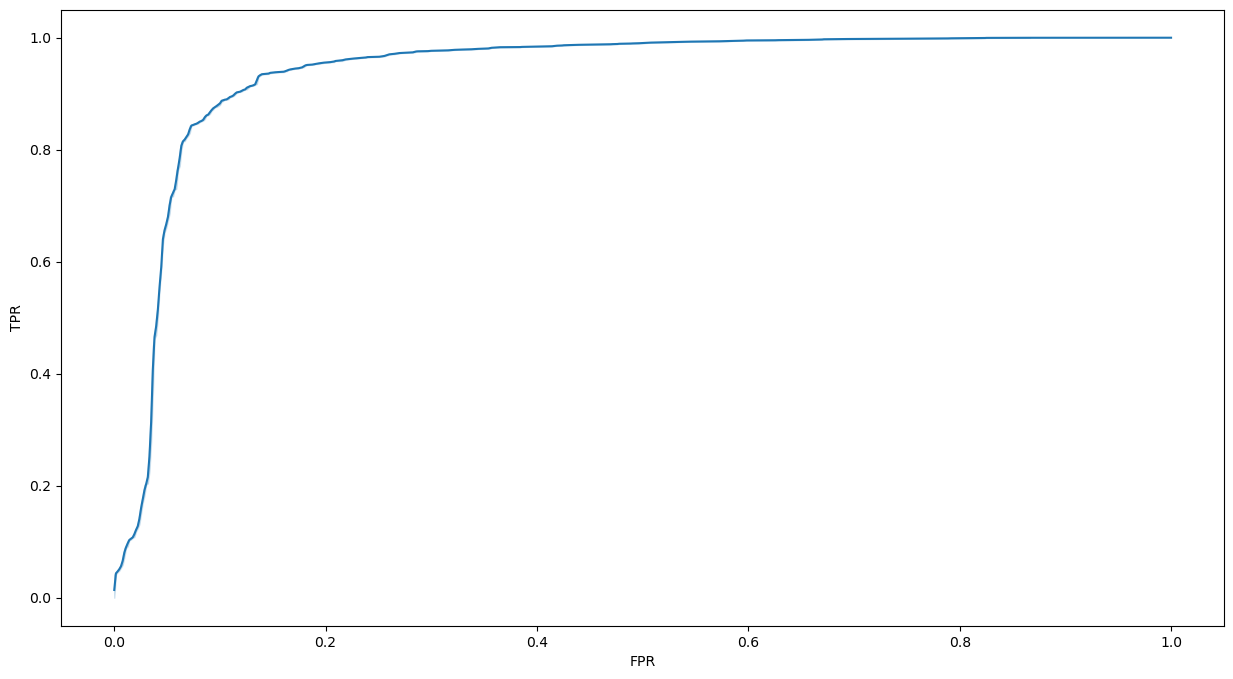

Cutoff Point:  0.8561478086891093
Confusion Matrix:-
 col_0          0     1
Revenue.Grid          
0.0           80   153
1.0            3  1795
              precision    recall  f1-score   support

         0.0       0.96      0.34      0.51       233
         1.0       0.92      1.00      0.96      1798

    accuracy                           0.92      2031
   macro avg       0.94      0.67      0.73      2031
weighted avg       0.93      0.92      0.91      2031



In [95]:
LR.auc_roc()

#### Random Forest

In [93]:
# Data Initialization
RF = Model(train_size=train_size)

# Data Pre-Processing
RF.drop_identifier()
RF.imputer()
RF.encode(preference=0)
RF.feature_construction()
RF.dummies(False)
RF.adasyn()
# Model Building
RF.random_forest()
compared_df = RF.evaluate()

Pre SMOTE: Counter({1.0: 5463, 0.0: 630})
Post SMOTE: Counter({0.0: 5492, 1.0: 5463})
Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           181    52
1.0            51  1747
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       233
         1.0       0.97      0.97      0.97      1798

    accuracy                           0.95      2031
   macro avg       0.88      0.87      0.87      2031
weighted avg       0.95      0.95      0.95      2031



In [60]:
# Hyperparameter Tuning

parameters = {
    "n_estimators" : [49,99,149,199,249,349],
    "max_features" : ['auto','sqrt',2,4,6,8,10],
    "max_depth" : [None,5,10,30,50,70,100,120,140],
    "min_samples_split" : [None,1,2,4,6,8,10],
    "min_samples_leaf" : [None,1,2,4,6,8],
    "bootstrap" : [True,False],
    "random_state" : [137]
}

rf_hyperparam_df = RF.hyper_param(RandomForestClassifier(),parameters,samples=10000)


Best Parameters:- 
{'random_state': 137, 'n_estimators': 49, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 100, 'bootstrap': True}
------------------------------------------------------------------------------------------



In [63]:
# Hypertuned Model
RF.tuned_random_forest()
compare_df = RF.evaluate()

Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0             0   233
1.0             1  1797
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       233
         1.0       0.89      1.00      0.94      1798

    accuracy                           0.88      2031
   macro avg       0.44      0.50      0.47      2031
weighted avg       0.78      0.88      0.83      2031



,children,age_band,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,year_last_moved,TVarea,...,status_Divorced/Separated,status_Partner,status_Single/Never Married,status_Widowed,gender_Female,gender_Male,gender_Unknown,source_predict,True,Predict
5742,0,6,6,9,1,12,1,1,1986,12,...,0,1,0,0,1,0,0,0,1.0,1.0
3192,1,8,9,3,1,11,1,1,1995,8,...,0,1,0,0,1,0,0,0,1.0,1.0
4517,1,4,8,8,1,1,1,1,1997,8,...,0,1,0,0,0,1,0,0,1.0,1.0
6119,0,7,8,4,1,11,1,1,1987,3,...,0,1,0,0,1,0,0,0,1.0,1.0
2162,0,6,6,9,1,11,1,1,1985,12,...,0,1,0,0,1,0,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,0,5,7,4,1,12,1,1,1997,11,...,0,1,0,0,1,0,0,0,1.0,1.0
7766,0,7,7,9,1,10,1,1,1988,12,...,0,1,0,0,1,0,0,0,1.0,1.0
4808,2,9,3,9,1,8,1,0,1982,8,...,1,0,0,0,1,0,0,0,1.0,1.0
7567,0,10,4,4,1,2,1,1,1972,9,...,0,1,0,0,0,1,0,0,1.0,1.0


#### KNN

In [104]:
# Data Initialization
KNN = Model(train_size=train_size)

# Data Pre-Processing
KNN.drop_identifier
KNN.imputer()
KNN.encode(preference=0)
KNN.feature_construction()
KNN.transform()
KNN.dummies(False)
KNN.scaling()
KNN.feature_selection()

# Model Building
KNN.knn()
compare_df = KNN.evaluate()

Selected features:-
['REF_NO', 'family_income', 'year_last_moved', 'Average.Credit.Card.Transaction', 'Balance.Transfer', 'Term.Deposit', 'Life.Insurance', 'Medical.Insurance', 'Average.A.C.Balance', 'Personal.Loan', 'Investment.in.Mutual.Fund', 'Investment.Tax.Saving.Bond', 'Home.Loan', 'Online.Purchase.Amount', 'Investment.in.Commudity', 'Investment.in.Equity', 'Investment.in.Derivative', 'Portfolio.Balance', 'Investment_Portfolio', 'Total_Debt', 'Investment_Debt_Ratio']
Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           131   102
1.0            18  1780
              precision    recall  f1-score   support

         0.0       0.88      0.56      0.69       233
         1.0       0.95      0.99      0.97      1798

    accuracy                           0.94      2031
   macro avg       0.91      0.78      0.83      2031
weighted avg       0.94      0.94      0.94      2031



In [102]:
# Hyperparameter Tuning
parameters = {
    'n_neighbors' : [1,3,5,7,9,11,13,15,17,20],
    'weights' : ['uniform','distance'],
    'p': [0.25,0.5,1,2,3,4,5,6],
    'leaf_size':[3,5,10,20,30,40,50,60]
}

knn_hyper_param_df = KNN.hyper_param(KNeighborsClassifier(),parameters,samples=10000,verbose=3)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits

Best Parameters:- 
{'weights': 'uniform', 'p': 4, 'n_neighbors': 3, 'leaf_size': 3}
------------------------------------------------------------------------------------------



In [106]:
# Hypertuned Model
KNN.tuned_knn()
compare_df = KNN.evaluate()

Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           141    92
1.0            24  1774
              precision    recall  f1-score   support

         0.0       0.85      0.61      0.71       233
         1.0       0.95      0.99      0.97      1798

    accuracy                           0.94      2031
   macro avg       0.90      0.80      0.84      2031
weighted avg       0.94      0.94      0.94      2031



#### Naive Bayes

In [108]:
# Data Initialization
NB = Model(train_size=train_size)

# Data Pre Processing
NB.drop_identifier
NB.imputer()
NB.encode(preference=1)
NB.feature_construction()
NB.pca()
NB.transform()
NB.dummies(False)
NB.feature_selection()
NB.scaling()


# Model Building
NB.naive_bayes()
compare_df = NB.evaluate()

Selected features:-
['post_code', 'post_area', 'Average.Credit.Card.Transaction', 'Life.Insurance', 'Personal.Loan', 'Investment.Tax.Saving.Bond', 'Online.Purchase.Amount', 'Investment.in.Commudity', 'Investment.in.Equity', 'Investment.in.Derivative', 'Portfolio.Balance', 'Investment_Portfolio', 'Total_Debt', 'PCA2']
Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0            18   215
1.0             1  1797
              precision    recall  f1-score   support

         0.0       0.95      0.08      0.14       233
         1.0       0.89      1.00      0.94      1798

    accuracy                           0.89      2031
   macro avg       0.92      0.54      0.54      2031
weighted avg       0.90      0.89      0.85      2031



#### Gradient Boosting

In [116]:
GB = Model(train_size=train_size)

# Data Pre-Processing
GB.drop_identifier()
GB.imputer()
GB.encode(preference=0)
GB.feature_construction()
GB.transform()
GB.dummies(False)
GB.scaling()
GB.feature_selection()

# Model Building
GB.grad_boost()
compare_df = GB.evaluate()

Selected features:-
['occupation', 'family_income', 'year_last_moved', 'Average.Credit.Card.Transaction', 'Balance.Transfer', 'Term.Deposit', 'Life.Insurance', 'Medical.Insurance', 'Average.A.C.Balance', 'Personal.Loan', 'Investment.in.Mutual.Fund', 'Investment.Tax.Saving.Bond', 'Home.Loan', 'Online.Purchase.Amount', 'Investment.in.Commudity', 'Investment.in.Equity', 'Investment.in.Derivative', 'Portfolio.Balance', 'Investment_Portfolio', 'Total_Debt', 'Investment_Debt_Ratio']
Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           177    56
1.0            26  1772
              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81       233
         1.0       0.97      0.99      0.98      1798

    accuracy                           0.96      2031
   macro avg       0.92      0.87      0.89      2031
weighted avg       0.96      0.96      0.96      2031



In [114]:
# Hyperparameter Tuning
parameters = {
    "n_estimators" : [49,99,149,199,249,349],
    "max_features" : ['auto','sqrt',1,2,4,6,8,10,12,14],
    "max_depth" : [None,3,5,10,15,20,30,50,70,100,120,140],
    "min_samples_split" : [None,1,2,4,6,8,10,12,14],
    "min_samples_leaf" : [None,1,2,4,6,8,10,12],
    "learning_rate" :[0.01,0.001,0.1,0.06,0.7,0.3,0.5,1,2,3],
    "random_state" : [137]
}

gb_hyperparam_df = GB.hyper_param(GradientBoostingClassifier(),parameters,samples=10000,verbose=3)

Fitting 3 folds for each of 10000 candidates, totalling 30000 fits

Best Parameters:- 
{'random_state': 137, 'n_estimators': 349, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 10, 'max_depth': 3, 'learning_rate': 0.3}
------------------------------------------------------------------------------------------



In [124]:
# Hypertuned Model
GB.tuned_grad_boost()
compare_df = GB.evaluate()

Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           186    47
1.0            18  1780
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85       233
         1.0       0.97      0.99      0.98      1798

    accuracy                           0.97      2031
   macro avg       0.94      0.89      0.92      2031
weighted avg       0.97      0.97      0.97      2031



#### SVM

In [155]:
# Data Initialization
SVM = Model(train_size=train_size)

# Data Pre-Processing
SVM.drop_identifier()
SVM.imputer()
SVM.encode(preference=0)
SVM.feature_construction()
SVM.transform()
SVM.dummies(True)
SVM.scaling()
SVM.feature_selection(0.01)

# Model Building
SVM.svm()
compare_df = SVM.evaluate()


Selected features:-
['occupation', 'year_last_moved', 'Average.Credit.Card.Transaction', 'Balance.Transfer', 'Term.Deposit', 'Life.Insurance', 'Medical.Insurance', 'Average.A.C.Balance', 'Personal.Loan', 'Investment.in.Mutual.Fund', 'Investment.Tax.Saving.Bond', 'Home.Loan', 'Online.Purchase.Amount', 'Investment.in.Commudity', 'Investment.in.Equity', 'Investment.in.Derivative', 'Portfolio.Balance', 'Investment_Portfolio', 'Total_Debt', 'Investment_Debt_Ratio']
Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           168    65
1.0            12  1786
              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81       233
         1.0       0.96      0.99      0.98      1798

    accuracy                           0.96      2031
   macro avg       0.95      0.86      0.90      2031
weighted avg       0.96      0.96      0.96      2031



In [138]:
# Hyperparameter Tuning
parameters = {
    'C': [199] + list(range(0,400,5)), 
    'gamma': [0.01,0.03,0.06,0.09,0.001,0.003,0.006,0.009, 0.1,0.13,0.16,0.19,0.22,0.25,0.28,0.31,0.34,0.37,0.4,0.43,0.46,0.49,0.52,0.55,0.58,0.61,0.64,0.67,0.7],
    'kernel': ['rbf','uniform','poly']
}

svm_hyperparam_df = SVM.hyper_param(model=SVC(),param=parameters,samples=10000,verbose=2,score="f1_macro")

Fitting 3 folds for each of 7047 candidates, totalling 21141 fits

Best Parameters:- 
{'kernel': 'rbf', 'gamma': 0.01, 'C': 385}
------------------------------------------------------------------------------------------



In [156]:
# Hypertuned Model
SVM.tuned_svm()
compare_df = SVM.evaluate()

Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           198    35
1.0            18  1780
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88       233
         1.0       0.98      0.99      0.99      1798

    accuracy                           0.97      2031
   macro avg       0.95      0.92      0.93      2031
weighted avg       0.97      0.97      0.97      2031



#### Training Evaluation

In [71]:
print("Testing Prediction:-")
SVM.evaluate()

print()
print("Training Prediction:-")
print("="*90)
y_predict = SVM.Model.predict(SVM.X_train)
print(classification_report(SVM.y_train,y_predict))

Testing Prediction:-
Confusion Matrix:-
 col_0         0.0   1.0
Revenue.Grid           
0.0           197    36
1.0            16  1782
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88       233
         1.0       0.98      0.99      0.99      1798

    accuracy                           0.97      2031
   macro avg       0.95      0.92      0.93      2031
weighted avg       0.97      0.97      0.97      2031

Training Prediction:-
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       630
         1.0       0.99      1.00      0.99      5463

    accuracy                           0.99      6093
   macro avg       0.98      0.95      0.96      6093
weighted avg       0.99      0.99      0.99      6093



#### Decile

In [157]:
SVM.decile2()

1 Decile [0 - 813]:
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94        85
         1.0       0.99      1.00      0.99       728

    accuracy                           0.99       813
   macro avg       0.98      0.95      0.97       813
weighted avg       0.99      0.99      0.99       813

2 Decile [813 - 1626]:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95        84
         1.0       0.99      1.00      0.99       729

    accuracy                           0.99       813
   macro avg       0.98      0.96      0.97       813
weighted avg       0.99      0.99      0.99       813

3 Decile [1626 - 2439]:
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92        95
         1.0       0.99      0.99      0.99       718

    accuracy                           0.98       813
   macro avg       0.97      0.94      0.95       813
weighte